In [227]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 두 개의 데이터 불러오기
daily_activity_34 = pd.read_csv('/Users/jisoyun/Desktop/sparta_python/Healthcare/sparta_15/data/dailyActivity_ 34.csv')
daily_activity_45 = pd.read_csv('/Users/jisoyun/Desktop/sparta_python/Healthcare/sparta_15/data/dailyActivity_45.csv')

# 데이터 합치기
act = pd.concat([daily_activity_34, daily_activity_45], ignore_index=True)

# 날짜 컬럼을 datetime으로 변환
act['ActivityDate'] = pd.to_datetime(act['ActivityDate'])

# 중복 제거 (같은 날짜/사용자가 두 파일에 있을 수 있음)
act = act.drop_duplicates(subset=['Id', 'ActivityDate'])

# 날짜순 정렬
act = act.sort_values(['Id', 'ActivityDate']).reset_index(drop=True)

print(f"합친 데이터 shape: {act.shape}")
print(f"날짜 범위: {act['ActivityDate'].min()} ~ {act['ActivityDate'].max()}")
print(f"총 사용자 수: {act['Id'].nunique()}명")
print(f"사용자당 평균 기록일: {act.groupby('Id').size().mean():.1f}일")

합친 데이터 shape: (1373, 15)
날짜 범위: 2016-03-12 00:00:00 ~ 2016-05-12 00:00:00
총 사용자 수: 35명
사용자당 평균 기록일: 39.2일


In [228]:
# 미착용일 제거
non_wear = (act['TotalSteps'] == 0) & (act['TotalDistance'] == 0) & (act['SedentaryMinutes'] >= 1380)
print(f"미착용일 수: {non_wear.sum()}개")
act = act[~non_wear].copy()

# 파생 변수 생성
act['weekday'] = act['ActivityDate'].dt.day_name()
act['is_weekend'] = act['weekday'].isin(['Saturday', 'Sunday'])
act['TotalActiveMinutes'] = (
    act['VeryActiveMinutes'] + 
    act['FairlyActiveMinutes'] + 
    act['LightlyActiveMinutes']
)

미착용일 수: 127개


In [229]:
# 사용자별 분석 (상위/하위 비교)
user_summary = act.groupby('Id').agg({
    'TotalSteps': 'mean',
    'Calories': 'mean',
    'TotalActiveMinutes': 'mean'
}).reset_index()

top5 = user_summary.nlargest(5, 'TotalSteps')
bottom5 = user_summary.nsmallest(5, 'TotalSteps')

# 요일별 분석 (주중 vs 주말)
weekday_summary = act.groupby('weekday').agg({
    'TotalSteps': 'mean',
    'Calories': 'mean'
})

In [230]:
distance_columns = [col for col in act.columns if 'Distance' in col]
for col in distance_columns:
    act[col] = act[col].round(3)

act.head()

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,weekday,is_weekend,TotalActiveMinutes
0,1503960366,2016-03-25,11004,7.11,7.11,0.0,2.57,0.46,4.07,0.0,33,12,205,804,1819,Friday,False,250
1,1503960366,2016-03-26,17609,11.55,11.55,0.0,6.92,0.73,3.91,0.0,89,17,274,588,2154,Saturday,True,380
2,1503960366,2016-03-27,12736,8.53,8.53,0.0,4.66,0.16,3.71,0.0,56,5,268,605,1944,Sunday,True,329
3,1503960366,2016-03-28,13231,8.93,8.93,0.0,3.19,0.79,4.95,0.0,39,20,224,1080,1932,Monday,False,283
4,1503960366,2016-03-29,12041,7.85,7.85,0.0,2.16,1.09,4.61,0.0,28,28,243,763,1886,Tuesday,False,299


In [231]:
act.info()

<class 'pandas.DataFrame'>
Index: 1246 entries, 0 to 1372
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Id                        1246 non-null   int64         
 1   ActivityDate              1246 non-null   datetime64[us]
 2   TotalSteps                1246 non-null   int64         
 3   TotalDistance             1246 non-null   float64       
 4   TrackerDistance           1246 non-null   float64       
 5   LoggedActivitiesDistance  1246 non-null   float64       
 6   VeryActiveDistance        1246 non-null   float64       
 7   ModeratelyActiveDistance  1246 non-null   float64       
 8   LightActiveDistance       1246 non-null   float64       
 9   SedentaryActiveDistance   1246 non-null   float64       
 10  VeryActiveMinutes         1246 non-null   int64         
 11  FairlyActiveMinutes       1246 non-null   int64         
 12  LightlyActiveMinutes      1246 non-n

In [296]:
# 2-2. Calorie 그룹 추가
bins = [0, 500, 1000, 1500, 2000, 2500, float('inf')]
labels = ['500 이하', '500-1000', '1000-1500', '1500-2000', '2000-2500', '2500 이상']
act['CalorieGroup'] = pd.cut(act['Calories'], bins=bins, labels=labels, right=False)

print("✓ CalorieGroup 컬럼 추가 완료")
print(f"\n칼로리 그룹별 데이터 개수:")
print(act['CalorieGroup'].value_counts().sort_index())

✓ CalorieGroup 컬럼 추가 완료

칼로리 그룹별 데이터 개수:
CalorieGroup
500 이하        12
500-1000      18
1000-1500    106
1500-2000    327
2000-2500    322
2500 이상      461
Name: count, dtype: int64


In [297]:
# act를 actcp로 복사
actcp = act.copy()
print(f"✓ actcp 생성 완료 (행 개수: {len(actcp)})")

✓ actcp 생성 완료 (행 개수: 1246)


In [298]:
# 3-1. 0값 확인
print("=== 0값 확인 ===")
numeric_cols = ['TotalSteps', 'TotalDistance', 'TrackerDistance',
                'LoggedActivitiesDistance', 'VeryActiveDistance',
                'ModeratelyActiveDistance', 'LightActiveDistance',
                'VeryActiveMinutes','FairlyActiveMinutes', 
                'LightlyActiveMinutes', 
                'SedentaryMinutes', 'Calories']

for col in numeric_cols:
    zero_count = (actcp[col] == 0).sum()
    if zero_count > 0:
        print(f"{col}: {zero_count}개 ({zero_count/len(actcp)*100:.1f}%)")

=== 0값 확인 ===
TotalSteps: 11개 (0.9%)
TotalDistance: 14개 (1.1%)
TrackerDistance: 17개 (1.4%)
LoggedActivitiesDistance: 1192개 (95.7%)
VeryActiveDistance: 523개 (42.0%)
ModeratelyActiveDistance: 479개 (38.4%)
LightActiveDistance: 32개 (2.6%)
VeryActiveMinutes: 517개 (41.5%)
FairlyActiveMinutes: 476개 (38.2%)
LightlyActiveMinutes: 29개 (2.3%)
SedentaryMinutes: 1개 (0.1%)


In [299]:
# 3-2. TotalSteps가 0인 행 제거 (기기 미착용으로 추정)
print(f"\n처리 전 행 개수: {len(actcp)}")

actcp_cleaned = actcp[actcp['TotalSteps'] > 0].copy()

print(f"처리 후 행 개수: {len(actcp_cleaned)}")
print(f"제거된 행 개수: {len(actcp) - len(actcp_cleaned)}")
print("✓ TotalSteps가 0인 행 제거 완료")


처리 전 행 개수: 1246
처리 후 행 개수: 1235
제거된 행 개수: 11
✓ TotalSteps가 0인 행 제거 완료


In [301]:
# 3-3. 이상치 확인 (IQR 방법)
print("\n=== IQR 방법 이상치 개수 ===")

outlier_cols = ['TotalSteps', 'TotalDistance', 'Calories', 'SedentaryMinutes']

for col in outlier_cols:
    Q1 = actcp_cleaned[col].quantile(0.25)
    Q3 = actcp_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = actcp_cleaned[(actcp_cleaned[col] < lower_bound) | (actcp_cleaned[col] > upper_bound)]
    
    if len(outliers) > 0:
        print(f"{col}: {len(outliers)}개 (하한: {lower_bound:.2f}, 상한: {upper_bound:.2f})")


=== IQR 방법 이상치 개수 ===
TotalSteps: 18개 (하한: -5239.75, 상한: 20726.25)
TotalDistance: 32개 (하한: -4.08, 상한: 14.91)
Calories: 14개 (하한: 379.75, 상한: 4281.75)
SedentaryMinutes: 2개 (하한: 11.50, 상한: 1895.50)


In [302]:
# 3-4. 이상치 제거
def remove_outliers_iqr(df, columns):
    """IQR 방법으로 이상치 제거"""
    df_clean = df.copy()
    
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # 이상치 제거
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    
    return df_clean

# 이상치 제거할 주요 컬럼
outlier_cols = ['TotalSteps', 'TotalDistance', 'Calories', 'SedentaryMinutes']

print(f"이상치 제거 전: {len(actcp_cleaned)}행")
actcp_final = remove_outliers_iqr(actcp_cleaned, outlier_cols)
print(f"이상치 제거 후: {len(actcp_final)}행")
print(f"제거된 행: {len(actcp_cleaned) - len(actcp_final)}행")
print("✓ 이상치 제거 완료")

이상치 제거 전: 1235행
이상치 제거 후: 1188행
제거된 행: 47행
✓ 이상치 제거 완료


In [303]:
# 4-1. 최종 데이터 정보
print("=== 최종 데이터 정보 ===")
print(f"행 개수: {len(actcp_final)}")
print(f"열 개수: {len(actcp_final.columns)}")
print(f"\n데이터 타입:\n{actcp_final.dtypes}")


=== 최종 데이터 정보 ===
행 개수: 1188
열 개수: 19

데이터 타입:
Id                                   int64
ActivityDate                datetime64[us]
TotalSteps                           int64
TotalDistance                      float64
TrackerDistance                    float64
LoggedActivitiesDistance           float64
VeryActiveDistance                 float64
ModeratelyActiveDistance           float64
LightActiveDistance                float64
SedentaryActiveDistance            float64
VeryActiveMinutes                    int64
FairlyActiveMinutes                  int64
LightlyActiveMinutes                 int64
SedentaryMinutes                     int64
Calories                             int64
weekday                                str
is_weekend                            bool
TotalActiveMinutes                   int64
CalorieGroup                      category
dtype: object


In [304]:
# 4-2. 주요 컬럼 통계
print("\n=== 주요 컬럼 기본 통계량 ===")
display(actcp_final[['TotalSteps', 'TotalDistance', 'Calories', 'VeryActiveMinutes', 'SedentaryMinutes']].describe())




=== 주요 컬럼 기본 통계량 ===


,TotalSteps,TotalDistance,Calories,VeryActiveMinutes,SedentaryMinutes
count,1188.000000,1188.000000,1188.000000,1188.000000,1188.000000
mean,7654.723906,5.403434,2291.970539,18.606902,955.994949
std,4239.488987,3.067950,667.301656,27.025331,287.995852
min,4.000000,0.000000,446.000000,0.000000,61.000000
25%,4367.500000,3.007500,1830.750000,0.000000,720.000000
50%,7420.500000,5.275000,2181.500000,4.000000,1003.500000
75%,10611.500000,7.547500,2780.250000,30.000000,1192.250000
max,20237.000000,14.710000,4163.000000,123.000000,1440.000000



=== 칼로리 그룹별 분포 ===
CalorieGroup
500 이하         2
500-1000      16
1000-1500    103
1500-2000    327
2000-2500    322
2500 이상      418
Name: count, dtype: int64


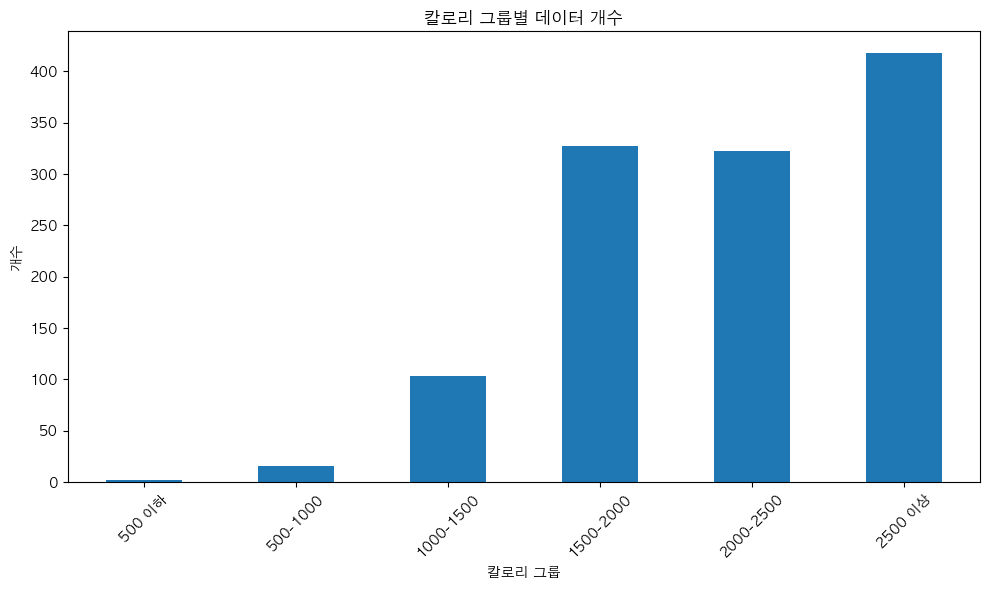

In [305]:
# 4-3. 칼로리 그룹별 분포
print("\n=== 칼로리 그룹별 분포 ===")
print(actcp_final['CalorieGroup'].value_counts().sort_index())

# 시각화
plt.figure(figsize=(10, 6))
actcp_final['CalorieGroup'].value_counts().sort_index().plot(kind='bar')
plt.title('칼로리 그룹별 데이터 개수')
plt.xlabel('칼로리 그룹')
plt.ylabel('개수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [306]:
actcp_d = actcp_final[actcp_final['CalorieGroup'] != '500 이하'].copy()

In [311]:
# 칼로리 그룹별 평균 계산
distance_cols = ['TotalSteps', 'TotalDistance', 'TrackerDistance', 
                'LoggedActivitiesDistance', 'VeryActiveDistance', 
                'ModeratelyActiveDistance', 'LightActiveDistance']

calorie_group_dis = actcp_d.groupby('CalorieGroup', observed=True)[distance_cols].mean().round(3)
calorie_group_dis


,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance
CalorieGroup,,,,,,,
500-1000,1914.625,1.272,1.272,0.000,0.248,0.118,0.904
1000-1500,3302.214,2.186,2.163,0.063,0.182,0.123,1.876
1500-2000,6512.844,4.336,4.336,0.007,0.719,0.545,3.055
2000-2500,7694.276,5.252,5.209,0.102,1.019,0.574,3.620
2500 이상,9843.196,7.330,7.280,0.301,2.055,0.778,4.264


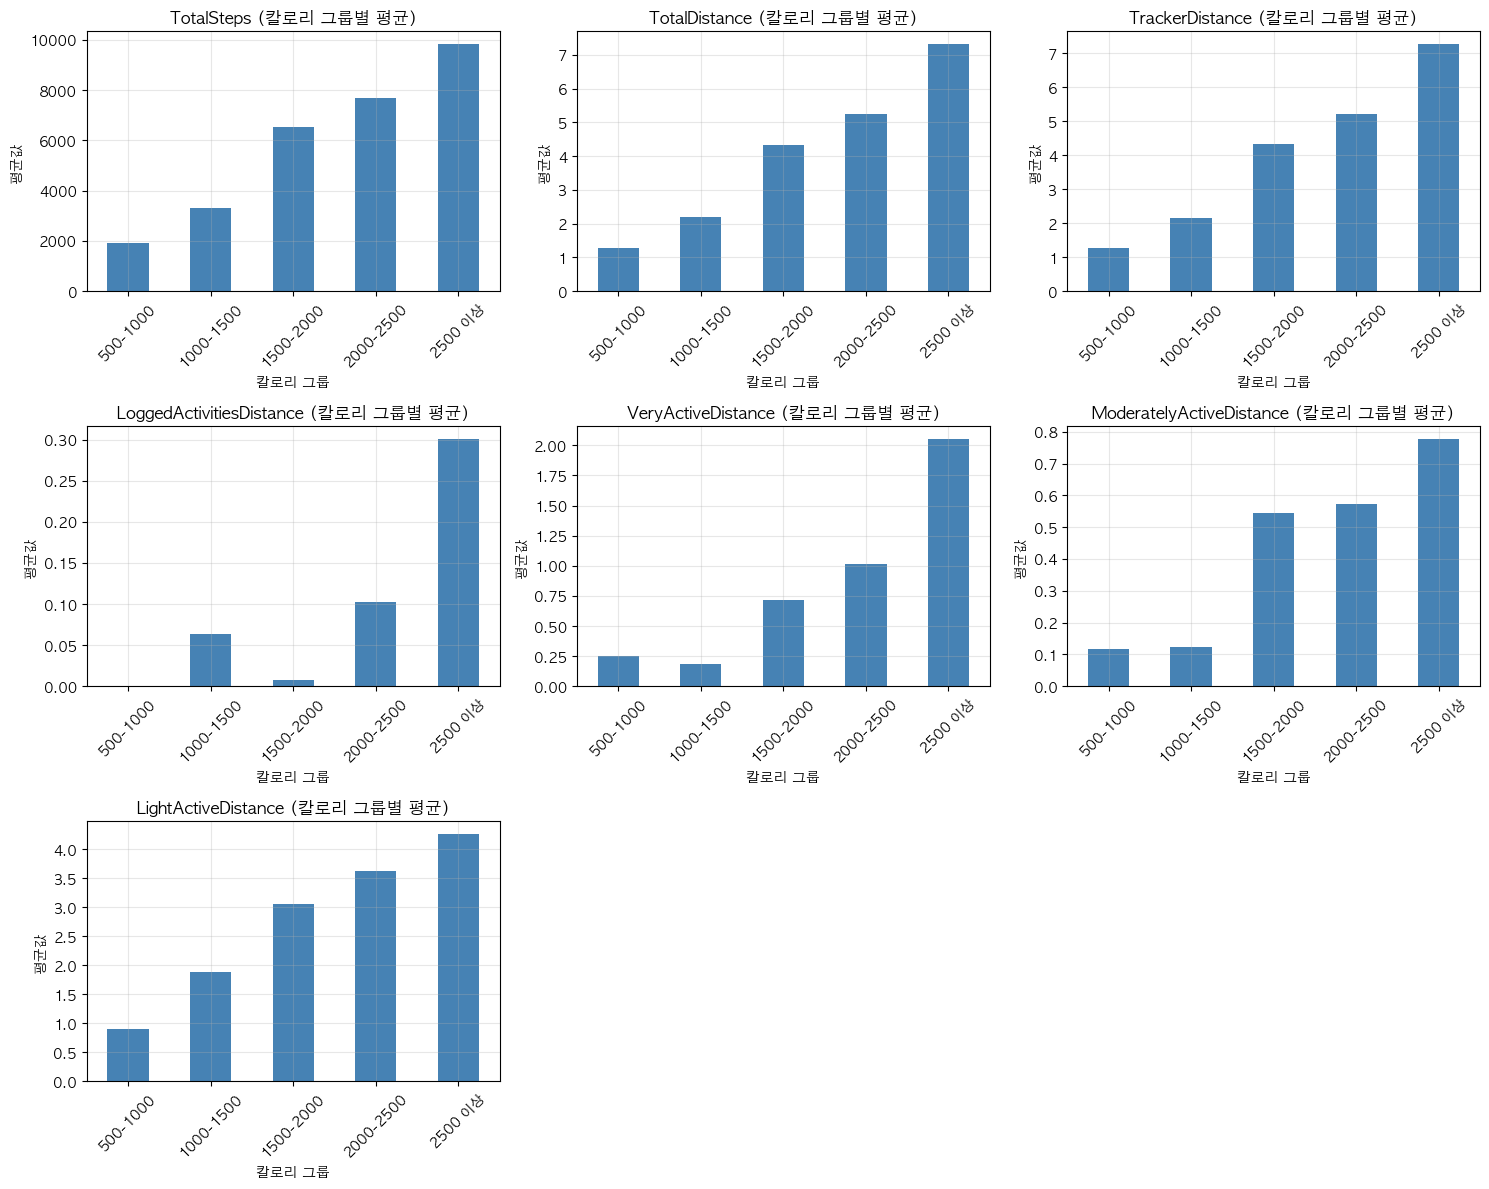

In [312]:
# 시각화 - 각 컬럼별로 그래프
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, col in enumerate(distance_cols):
    calorie_group_dis[col].plot(kind='bar', ax=axes[idx], color='steelblue')
    axes[idx].set_title(f'{col} (칼로리 그룹별 평균)')
    axes[idx].set_xlabel('칼로리 그룹')
    axes[idx].set_ylabel('평균값')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True, alpha=0.3)

# 남은 subplot 제거
for idx in range(len(distance_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

In [315]:
# 칼로리 그룹별 활동 시간 평균 계산
activity_cols = ['VeryActiveMinutes', 'FairlyActiveMinutes', 
                'LightlyActiveMinutes', 'SedentaryMinutes']

calorie_group_t = actcp_d.groupby('CalorieGroup', observed=True)[activity_cols].mean().round(3)
calorie_group_t

,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes
CalorieGroup,,,,
500-1000,3.625,2.125,42.375,360.812
1000-1500,2.447,2.680,128.728,999.262
1500-2000,9.963,12.055,198.021,987.700
2000-2500,14.326,12.152,227.770,942.994
2500 이상,33.311,20.450,219.943,956.639


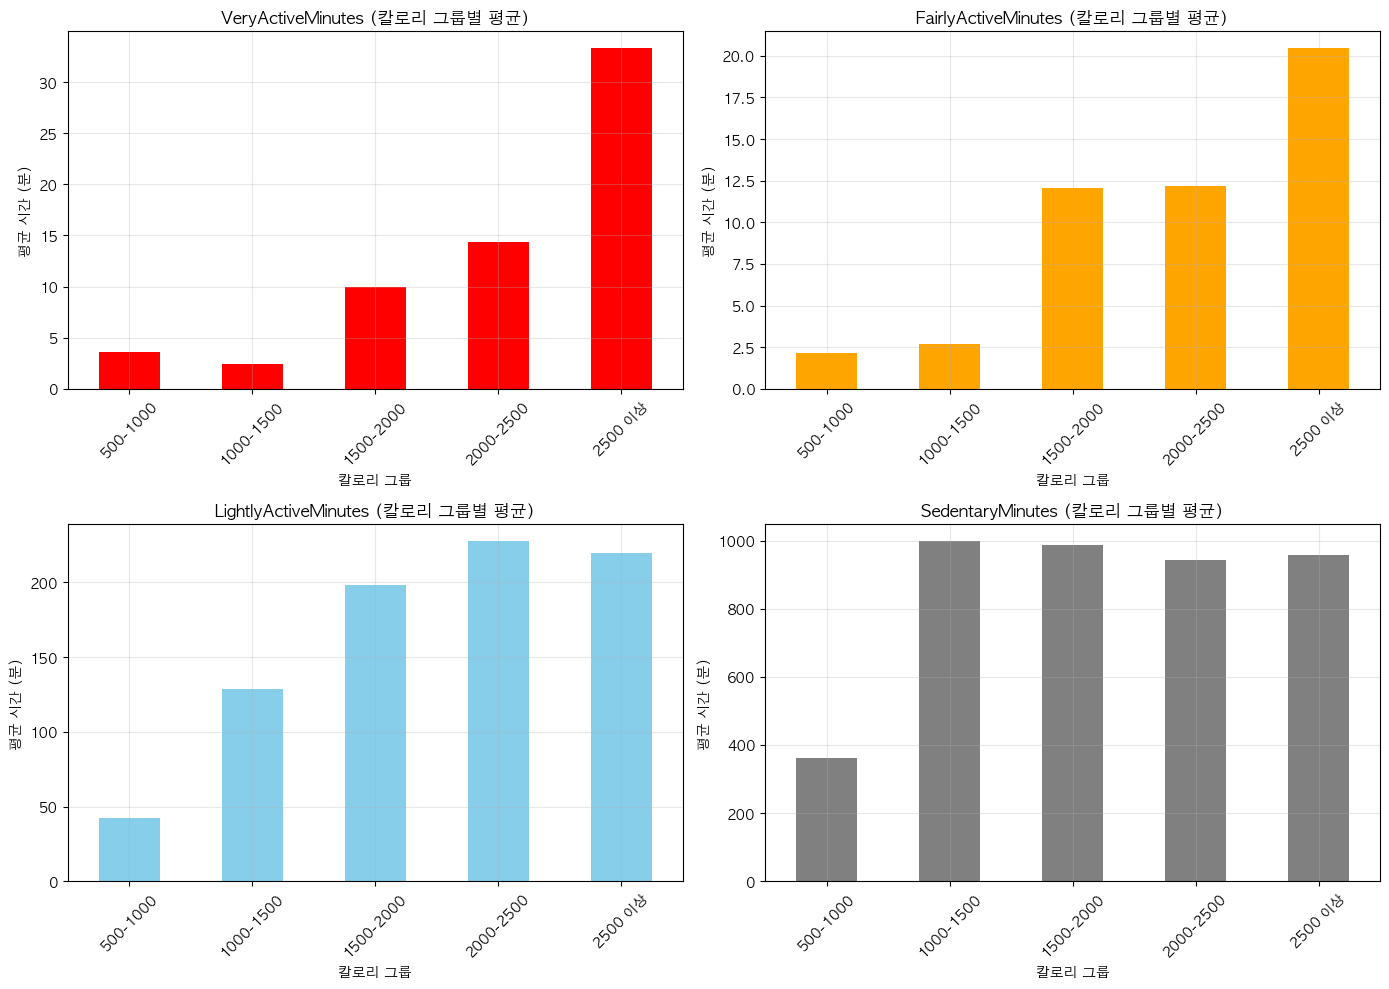

In [316]:
# 시각화 - 각 활동 시간별로 그래프
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

colors = ['red', 'orange', 'skyblue', 'gray']

for idx, col in enumerate(activity_cols):
    calorie_group_t[col].plot(kind='bar', ax=axes[idx], color=colors[idx])
    axes[idx].set_title(f'{col} (칼로리 그룹별 평균)', fontsize=12)
    axes[idx].set_xlabel('칼로리 그룹')
    axes[idx].set_ylabel('평균 시간 (분)')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

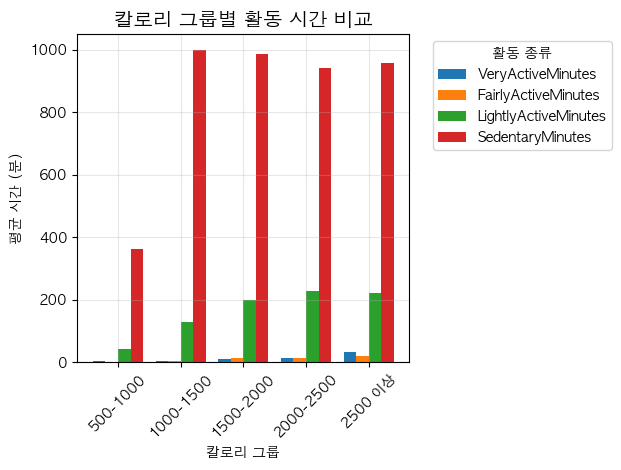

In [317]:
# 모든 활동 시간을 하나의 그래프로 비교
plt.figure(figsize=(12, 6))
calorie_group_t.plot(kind='bar', width=0.8)
plt.title('칼로리 그룹별 활동 시간 비교', fontsize=14)
plt.xlabel('칼로리 그룹')
plt.ylabel('평균 시간 (분)')
plt.legend(title='활동 종류', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [318]:
# 데이터프레임으로 보기 좋게 출력
print("\n=== 칼로리 그룹별 활동 시간 상세 통계 ===")
display(calorie_group_t)

# 총 활동 시간도 계산
calorie_group_t['TotalActiveMinutes'] = (
    calorie_group_t['VeryActiveMinutes'] + 
    calorie_group_t['FairlyActiveMinutes'] +
    calorie_group_t['LightlyActiveMinutes']
).round(3)

print("\n=== 총 활동 시간 포함 ===")
display(calorie_group_t)


=== 칼로리 그룹별 활동 시간 상세 통계 ===


,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes
CalorieGroup,,,,
500-1000,3.625,2.125,42.375,360.812
1000-1500,2.447,2.680,128.728,999.262
1500-2000,9.963,12.055,198.021,987.700
2000-2500,14.326,12.152,227.770,942.994
2500 이상,33.311,20.450,219.943,956.639



=== 총 활동 시간 포함 ===


,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,TotalActiveMinutes
CalorieGroup,,,,,
500-1000,3.625,2.125,42.375,360.812,48.125
1000-1500,2.447,2.680,128.728,999.262,133.855
1500-2000,9.963,12.055,198.021,987.700,220.039
2000-2500,14.326,12.152,227.770,942.994,254.248
2500 이상,33.311,20.450,219.943,956.639,273.704


In [319]:
# actcp_cleaned에서 파생 변수 생성 (0값 제거 후, 이상치 제거 전)
# 1. 평균 속도 (km/h) - 총 거리 / 총 활동 시간
actcp_d['TotalActiveMinutes'] = (actcp_d['VeryActiveMinutes'] + 
                                        actcp_d['FairlyActiveMinutes'] + 
                                        actcp_d['LightlyActiveMinutes'])
actcp_d['AvgSpeed_kmh'] = (actcp_d['TotalDistance'] / 
                                  (actcp_d['TotalActiveMinutes'] / 60)).round(3)
# 2. 평균 페이스 (분/km) - 총 활동 시간 / 총 거리
actcp_d['AvgPace_min_per_km'] = (actcp_d['TotalActiveMinutes'] / 
                                        actcp_d['TotalDistance']).round(3)

# 3. 보폭 (미터) - 총 거리 / 총 걸음 수
actcp_d['AvgStride_m'] = ((actcp_d['TotalDistance'] * 1000) / 
                                 actcp_d['TotalSteps']).round(3)

# 4. 활동 강도 비율
actcp_d['VeryActiveRatio'] = (actcp_d['VeryActiveMinutes'] /
                                     actcp_d['TotalActiveMinutes']).round(3)
actcp_d['LightActiveRatio'] = (actcp_d['LightlyActiveMinutes'] / 
                                      actcp_d['TotalActiveMinutes']).round(3)

# 5. 칼로리 효율 (칼로리/km)
# 거리가 너무 짧은 데이터 제외 (0.5km 미만)
actcp_d['CaloriesPerKm'] = np.where(
    actcp_d['TotalDistance'] >= 0.5,  # 0.5km 이상만
    actcp_d['Calories'] / actcp_d['TotalDistance'],
    np.nan  # 0.5km 미만은 결측값 처리
)

# 칼로리 그룹별 재집계 (결측값 제외)
calorie_group_derived = actcp_d.groupby('CalorieGroup').agg({
    'TotalActiveMinutes': 'mean',
    'AvgSpeed_kmh': 'mean',
    'AvgPace_min_per_km': 'mean',
    'AvgStride_m': 'mean',
    'VeryActiveRatio': 'mean',
    'LightActiveRatio': 'mean',
    'CaloriesPerKm': 'mean'  # 결측값 제외한 평균
}).round(3)

# 0으로 나누는 경우 inf나 nan 처리
actcp_d.replace([np.inf, -np.inf], np.nan, inplace=True)

print("✓ 파생 변수 생성 완료")
print(f"생성된 변수: TotalActiveMinutes, AvgSpeed_kmh, AvgPace_min_per_km, AvgStride_m, VeryActiveRatio, LightActiveRatio, CaloriesPerKm")



✓ 파생 변수 생성 완료
생성된 변수: TotalActiveMinutes, AvgSpeed_kmh, AvgPace_min_per_km, AvgStride_m, VeryActiveRatio, LightActiveRatio, CaloriesPerKm


In [322]:
def remove_outliers_iqr(df, columns):
    """IQR 방법으로 이상치 제거"""
    df_clean = df.copy()
    
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        before_count = len(df_clean)
        # 이상치 제거
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
        after_count = len(df_clean)
        
        print(f"  - {col}: {before_count - after_count}개 제거 (기준: {lower_bound:.1f} ~ {upper_bound:.1f})")
    
    return df_clean

# 이상치 제거할 칼럼 (문자열 리스트로!)
outlier_cols = ['TotalActiveMinutes', 'AvgSpeed_kmh', 'AvgPace_min_per_km', 
                'AvgStride_m', 'VeryActiveRatio', 'LightActiveRatio', 'CaloriesPerKm']

print("=== IQR 이상치 제거 ===")
before_len = len(actcp_d)
print(f"이상치 제거 전: {before_len}행")

actcp_d_clean = remove_outliers_iqr(actcp_d, outlier_cols)

print(f"\n이상치 제거 후: {len(actcp_d_clean)}행")
print(f"총 제거된 행: {before_len - len(actcp_d_clean)}행 ({(before_len - len(actcp_d_clean))/before_len*100:.1f}%)")
print("✓ 이상치 제거 완료")

# 제거 후 CaloriesPerKm 분포 확인
print("\n=== CaloriesPerKm 제거 후 분포 ===")
print(actcp_d_clean['CaloriesPerKm'].describe())

# 그룹별 개수 확인
print("\n=== 칼로리 그룹별 분포 ===")
print(actcp_d_clean['CalorieGroup'].value_counts().sort_index())

=== IQR 이상치 제거 ===
이상치 제거 전: 1186행
  - TotalActiveMinutes: 3개 제거 (기준: -62.4 ~ 544.6)
  - AvgSpeed_kmh: 44개 제거 (기준: -0.2 ~ 2.7)
  - AvgPace_min_per_km: 15개 제거 (기준: -7.6 ~ 111.9)
  - AvgStride_m: 7개 제거 (기준: 0.5 ~ 0.9)
  - VeryActiveRatio: 59개 제거 (기준: -0.2 ~ 0.3)
  - LightActiveRatio: 16개 제거 (기준: 0.5 ~ 1.3)
  - CaloriesPerKm: 116개 제거 (기준: -152.9 ~ 1109.0)

이상치 제거 후: 926행
총 제거된 행: 260행 (21.9%)
✓ 이상치 제거 완료

=== CaloriesPerKm 제거 후 분포 ===
count     926.000000
mean      460.558042
std       200.879023
min       131.166667
25%       311.891550
50%       407.831016
75%       559.824588
max      1108.144796
Name: CaloriesPerKm, dtype: float64

=== 칼로리 그룹별 분포 ===
CalorieGroup
500 이하         0
500-1000       7
1000-1500     64
1500-2000    270
2000-2500    264
2500 이상      321
Name: count, dtype: int64


In [323]:
# 이제 칼로리 그룹별 파생 변수 평균 계산
derived_cols = ['TotalActiveMinutes', 'AvgSpeed_kmh', 'AvgPace_min_per_km', 
                'AvgStride_m', 'VeryActiveRatio', 'LightActiveRatio', 'CaloriesPerKm']

calorie_group_derived = actcp_d_clean.groupby('CalorieGroup', observed=True)[derived_cols].mean().round(3)

print("=== 칼로리 그룹별 파생 변수 평균 ===")
display(calorie_group_derived)

=== 칼로리 그룹별 파생 변수 평균 ===


,TotalActiveMinutes,AvgSpeed_kmh,AvgPace_min_per_km,AvgStride_m,VeryActiveRatio,LightActiveRatio,CaloriesPerKm
CalorieGroup,,,,,,,
500-1000,72.857,1.360,54.729,0.668,0.033,0.920,563.842
1000-1500,168.172,1.050,64.996,0.655,0.014,0.965,579.483
1500-2000,250.874,1.180,56.987,0.666,0.041,0.910,442.571
2000-2500,291.670,1.260,52.119,0.684,0.057,0.896,436.609
2500 이상,290.312,1.493,42.879,0.745,0.081,0.847,469.420


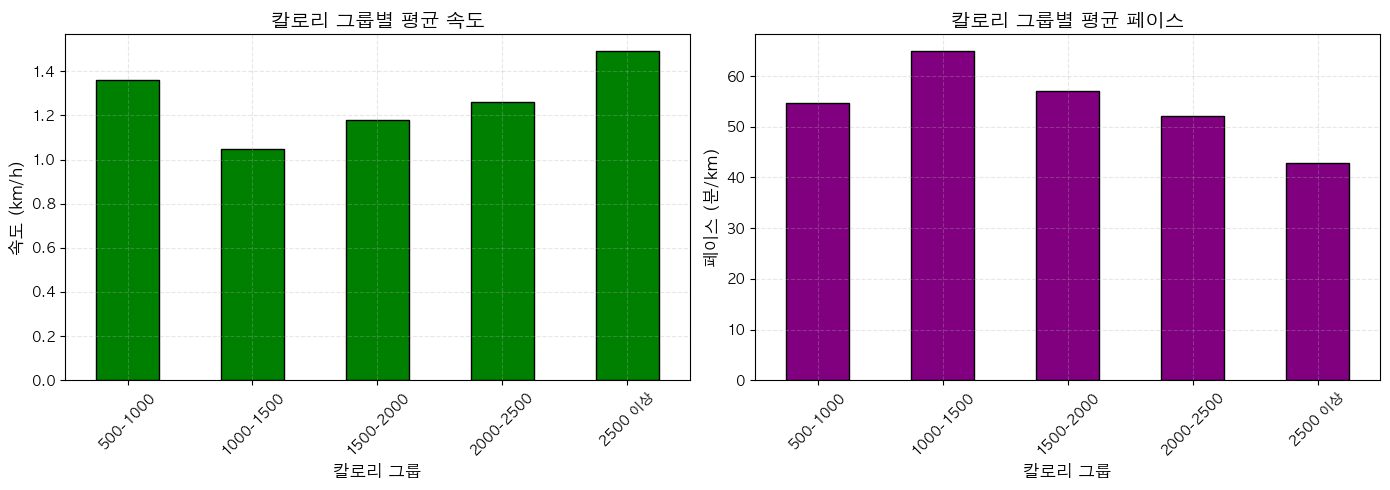

In [324]:
# 1. 속도와 페이스 비교
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 평균 속도
calorie_group_derived['AvgSpeed_kmh'].plot(kind='bar', ax=axes[0], color='green', edgecolor='black')
axes[0].set_title('칼로리 그룹별 평균 속도', fontsize=14, fontweight='bold')
axes[0].set_xlabel('칼로리 그룹', fontsize=12)
axes[0].set_ylabel('속도 (km/h)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, linestyle='--')

# 평균 페이스
calorie_group_derived['AvgPace_min_per_km'].plot(kind='bar', ax=axes[1], color='purple', edgecolor='black')
axes[1].set_title('칼로리 그룹별 평균 페이스', fontsize=14, fontweight='bold')
axes[1].set_xlabel('칼로리 그룹', fontsize=12)
axes[1].set_ylabel('페이스 (분/km)', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

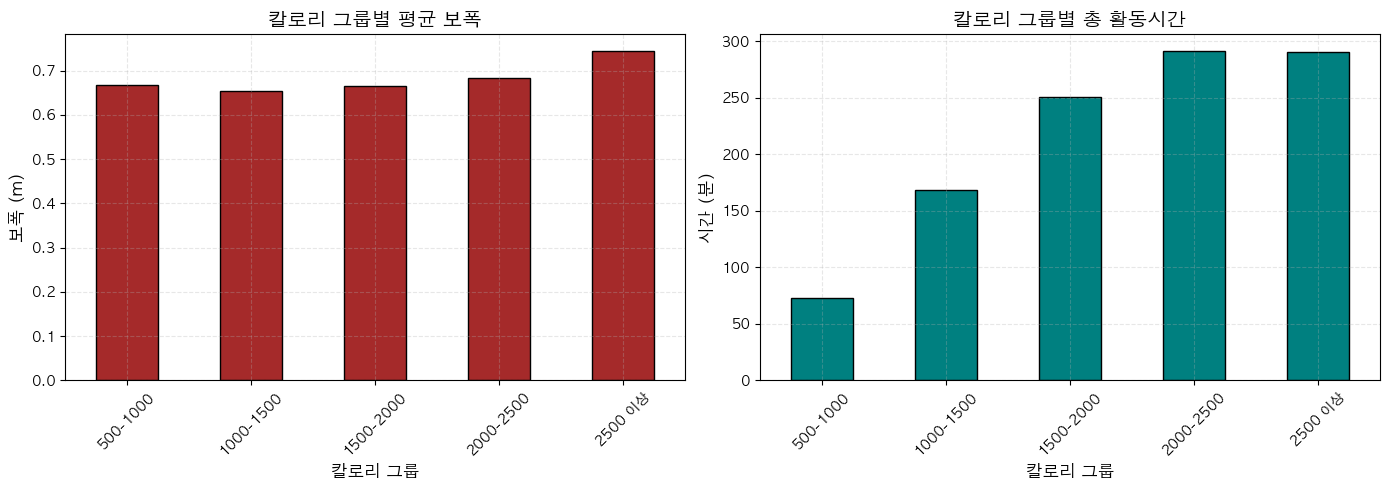

In [325]:
# 2. 보폭과 총 활동시간
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 평균 보폭
calorie_group_derived['AvgStride_m'].plot(kind='bar', ax=axes[0], color='brown', edgecolor='black')
axes[0].set_title('칼로리 그룹별 평균 보폭', fontsize=14, fontweight='bold')
axes[0].set_xlabel('칼로리 그룹', fontsize=12)
axes[0].set_ylabel('보폭 (m)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, linestyle='--')

# 총 활동시간
calorie_group_derived['TotalActiveMinutes'].plot(kind='bar', ax=axes[1], color='teal', edgecolor='black')
axes[1].set_title('칼로리 그룹별 총 활동시간', fontsize=14, fontweight='bold')
axes[1].set_xlabel('칼로리 그룹', fontsize=12)
axes[1].set_ylabel('시간 (분)', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

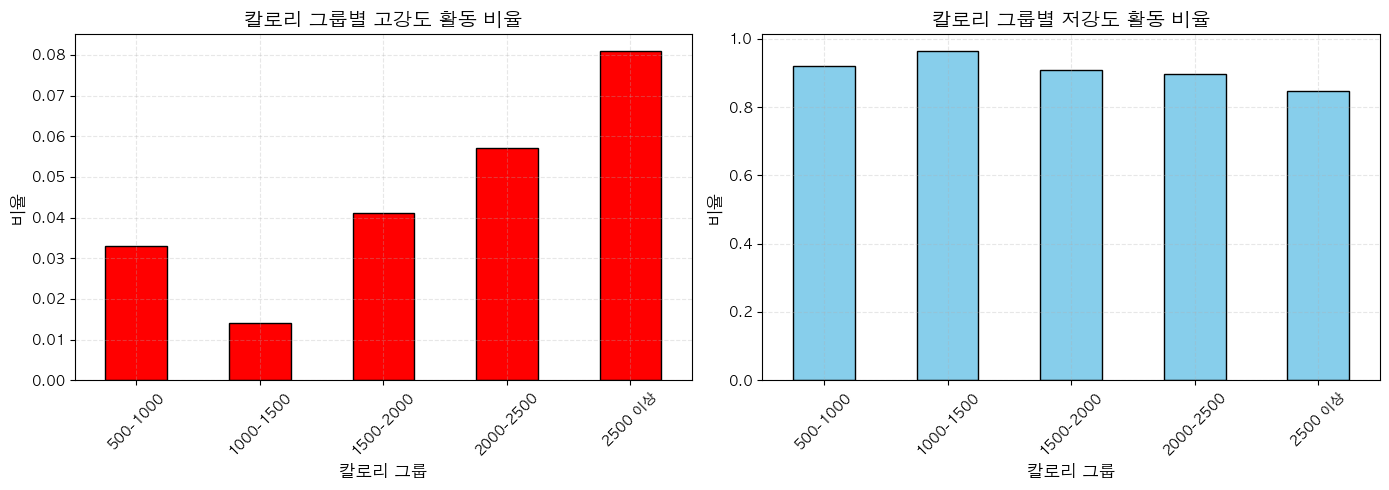

In [326]:
# 3. 활동 강도 비율 비교
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Very Active 비율
calorie_group_derived['VeryActiveRatio'].plot(kind='bar', ax=axes[0], color='red', edgecolor='black')
axes[0].set_title('칼로리 그룹별 고강도 활동 비율', fontsize=14, fontweight='bold')
axes[0].set_xlabel('칼로리 그룹', fontsize=12)
axes[0].set_ylabel('비율', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, linestyle='--')

# Light Active 비율
calorie_group_derived['LightActiveRatio'].plot(kind='bar', ax=axes[1], color='skyblue', edgecolor='black')
axes[1].set_title('칼로리 그룹별 저강도 활동 비율', fontsize=14, fontweight='bold')
axes[1].set_xlabel('칼로리 그룹', fontsize=12)
axes[1].set_ylabel('비율', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

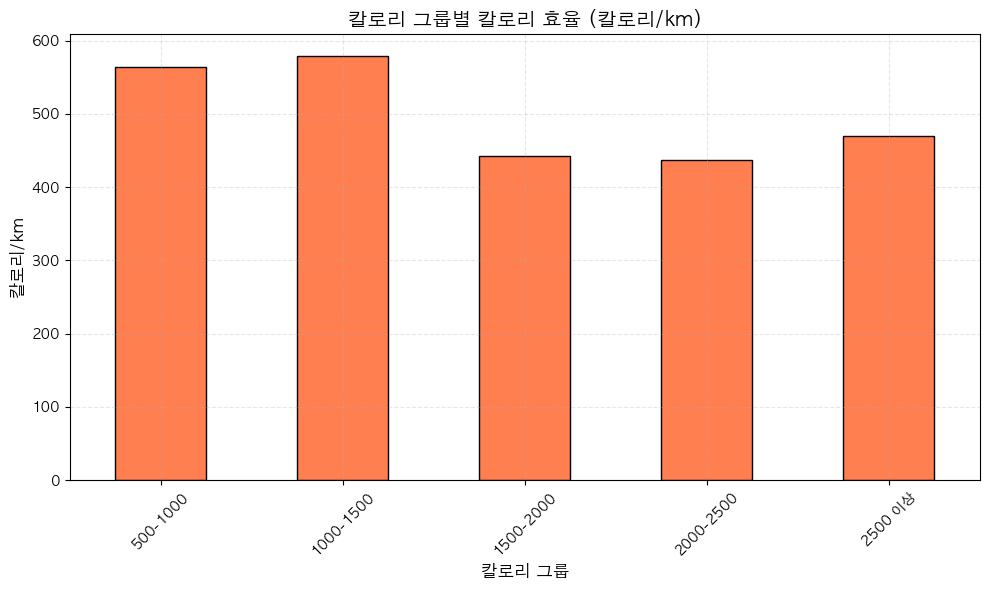

In [327]:
# 4. 칼로리 효율
plt.figure(figsize=(10, 6))
calorie_group_derived['CaloriesPerKm'].plot(kind='bar', color='coral', edgecolor='black')
plt.title('칼로리 그룹별 칼로리 효율 (칼로리/km)', fontsize=14, fontweight='bold')
plt.xlabel('칼로리 그룹', fontsize=12)
plt.ylabel('칼로리/km', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

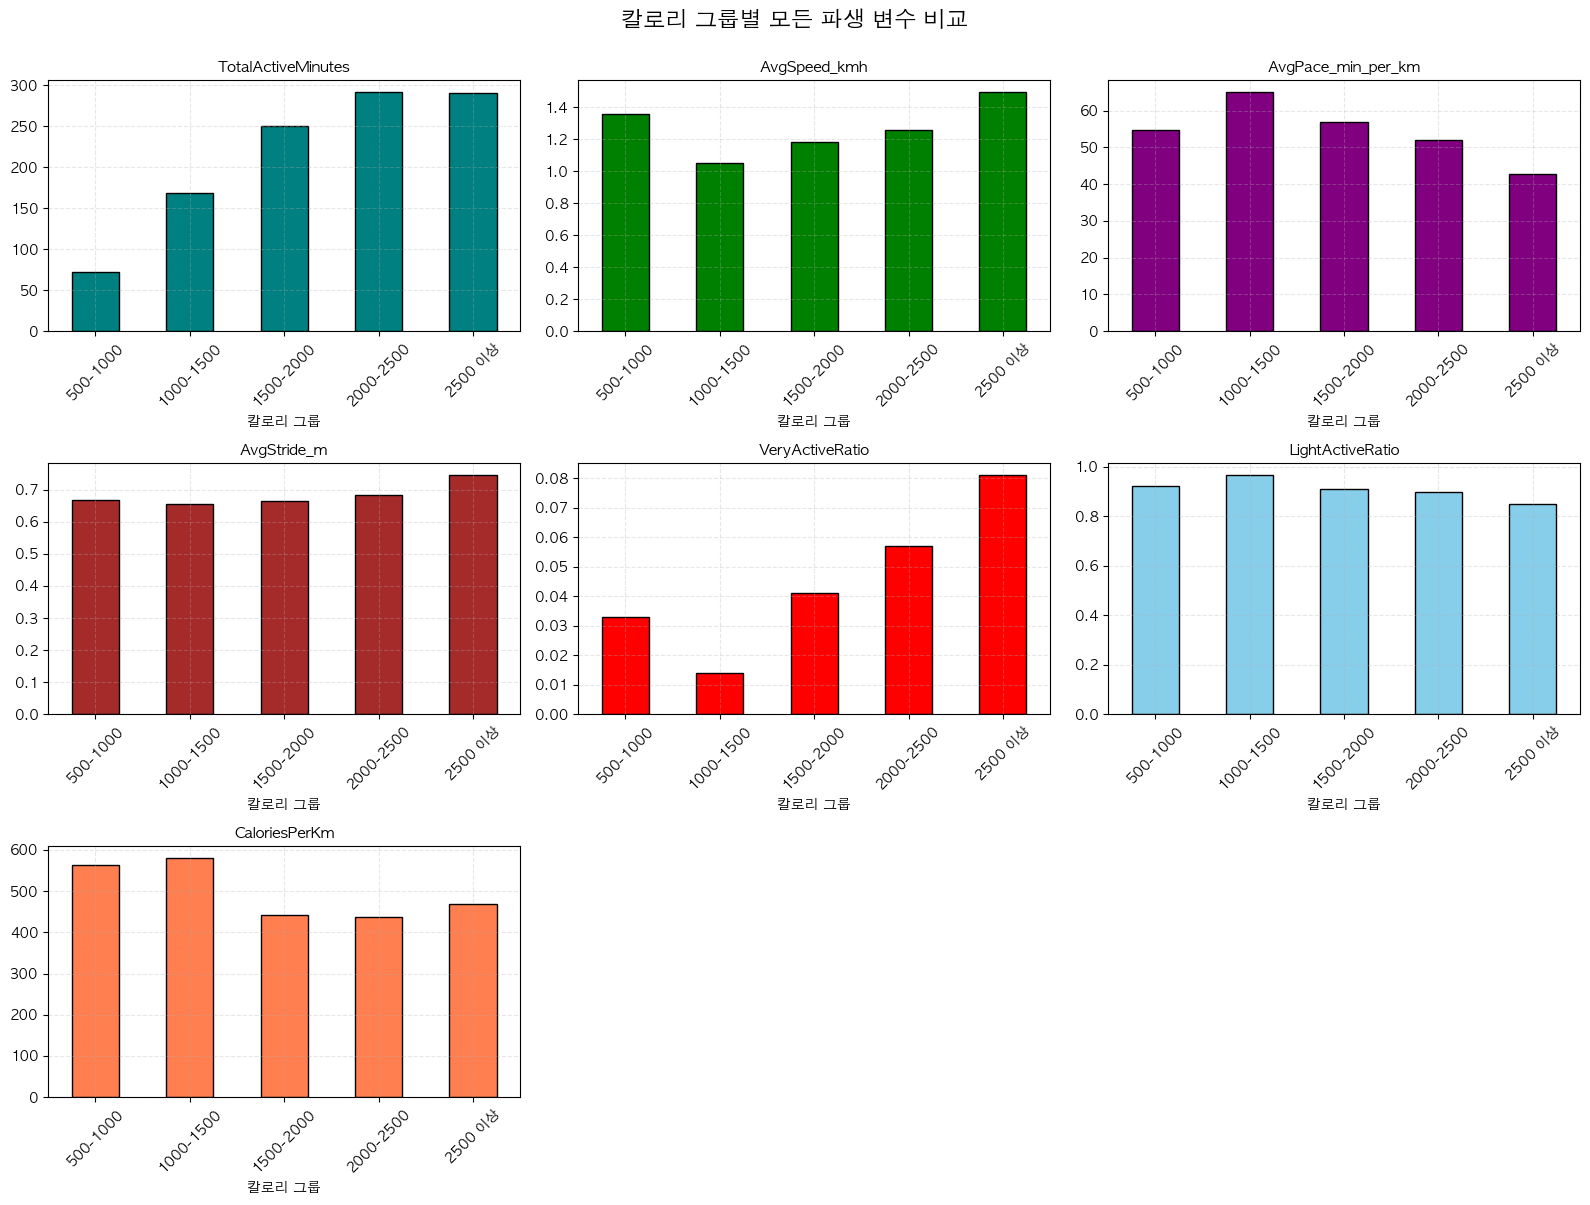

In [328]:
# 5. 모든 파생 변수 한번에 비교 (서브플롯)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

colors = ['teal', 'green', 'purple', 'brown', 'red', 'skyblue', 'coral']

for idx, col in enumerate(derived_cols):
    calorie_group_derived[col].plot(kind='bar', ax=axes[idx], 
                                    color=colors[idx], edgecolor='black')
    axes[idx].set_title(f'{col}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('칼로리 그룹', fontsize=10)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True, alpha=0.3, linestyle='--')

# 남은 subplot 제거
for idx in range(len(derived_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('칼로리 그룹별 모든 파생 변수 비교', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

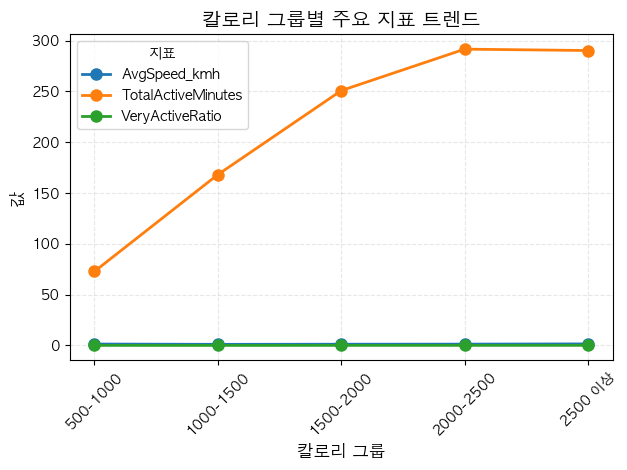

In [329]:
# 6. 라인 차트로 트렌드 확인
plt.figure(figsize=(12, 6))
calorie_group_derived[['AvgSpeed_kmh', 'TotalActiveMinutes', 'VeryActiveRatio']].plot(
    kind='line', marker='o', linewidth=2, markersize=8
)
plt.title('칼로리 그룹별 주요 지표 트렌드', fontsize=14, fontweight='bold')
plt.xlabel('칼로리 그룹', fontsize=12)
plt.ylabel('값', fontsize=12)
plt.legend(title='지표', fontsize=10)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(range(len(calorie_group_derived)), calorie_group_derived.index, rotation=45)
plt.tight_layout()
plt.show()

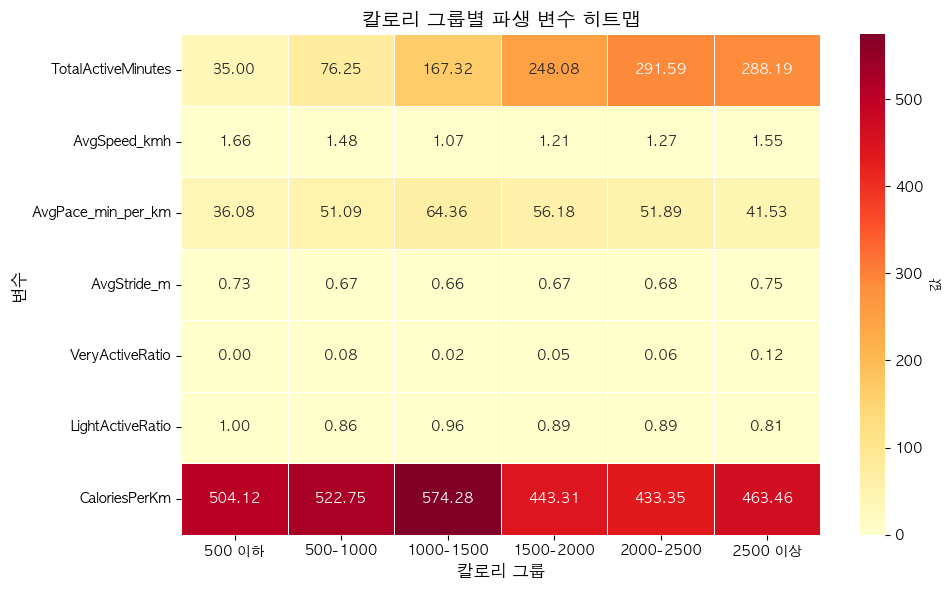

In [288]:
# 7. 히트맵으로 모든 변수 한눈에 보기
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(calorie_group_derived.T, annot=True, fmt='.2f', 
            cmap='YlOrRd', cbar_kws={'label': '값'}, linewidths=0.5)
plt.title('칼로리 그룹별 파생 변수 히트맵', fontsize=14, fontweight='bold')
plt.xlabel('칼로리 그룹', fontsize=12)
plt.ylabel('변수', fontsize=12)
plt.tight_layout()
plt.show()

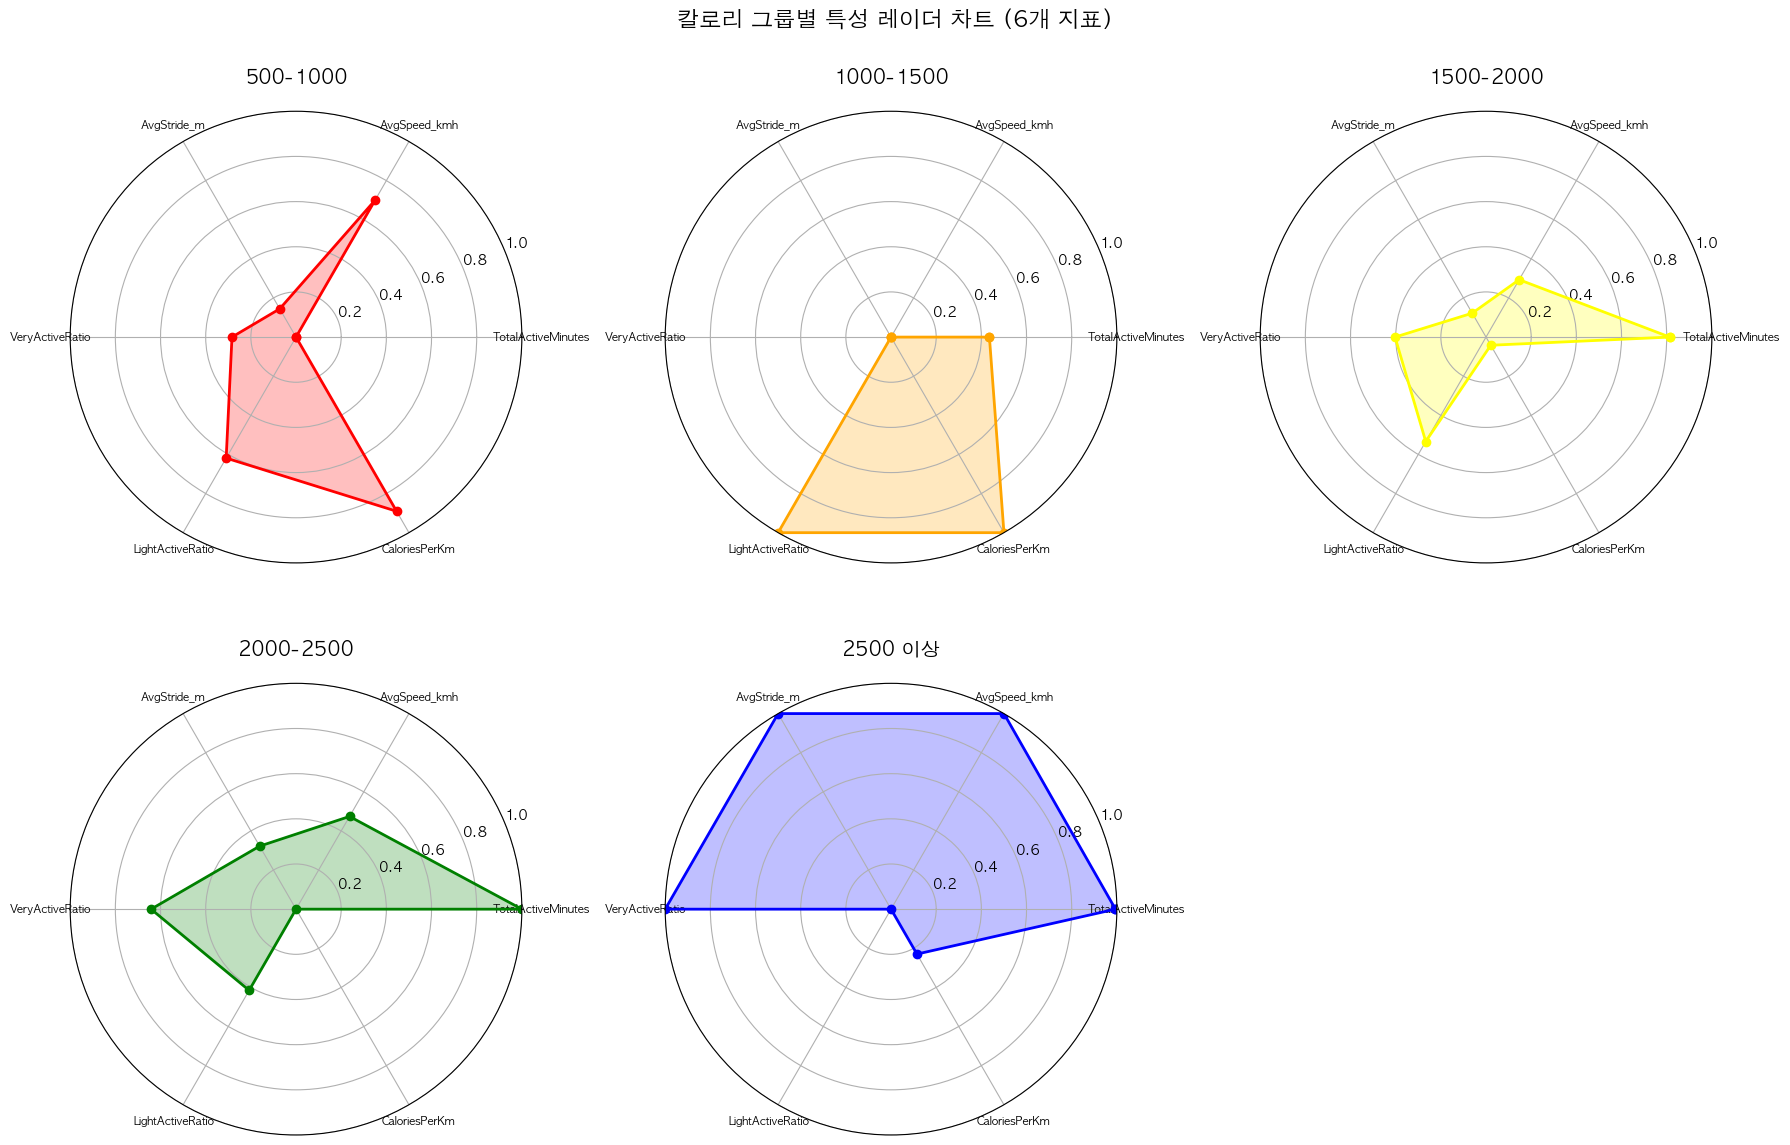

In [339]:
from sklearn.preprocessing import MinMaxScaler

# AvgPace_min_per_km 제외한 컬럼만 선택
radar_columns = ['TotalActiveMinutes', 'AvgSpeed_kmh', 'AvgStride_m', 
                 'VeryActiveRatio', 'LightActiveRatio', 'CaloriesPerKm']

calorie_group_radar = calorie_group_derived[radar_columns]

# 정규화
scaler = MinMaxScaler()
calorie_group_derived_normalized = pd.DataFrame(
    scaler.fit_transform(calorie_group_radar),
    index=calorie_group_radar.index,
    columns=calorie_group_radar.columns
)

# 1. 레이더 차트 (각 칼로리 그룹의 특성을 한눈에)
import numpy as np
from math import pi

# 데이터 준비
categories = list(calorie_group_derived_normalized.columns)
N = len(categories)

# 각도 계산
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# 플롯 생성
fig, axes = plt.subplots(2, 3, figsize=(18, 12), subplot_kw=dict(projection='polar'))
axes = axes.flatten()

colors = ['red', 'orange', 'yellow', 'green', 'blue']  # 5개 그룹이므로 5개 색상

for idx, (group, color) in enumerate(zip(calorie_group_derived_normalized.index, colors)):
    ax = axes[idx]
    
    values = calorie_group_derived_normalized.loc[group].values.tolist()
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=group, color=color)
    ax.fill(angles, values, alpha=0.25, color=color)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, size=8)
    ax.set_ylim(0, 1)
    ax.set_title(f'{group}', size=14, fontweight='bold', pad=20)
    ax.grid(True)

# 6번째 subplot은 비우기 (5개 그룹만 있으므로)
axes[5].axis('off')

plt.suptitle('칼로리 그룹별 특성 레이더 차트 (6개 지표)', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

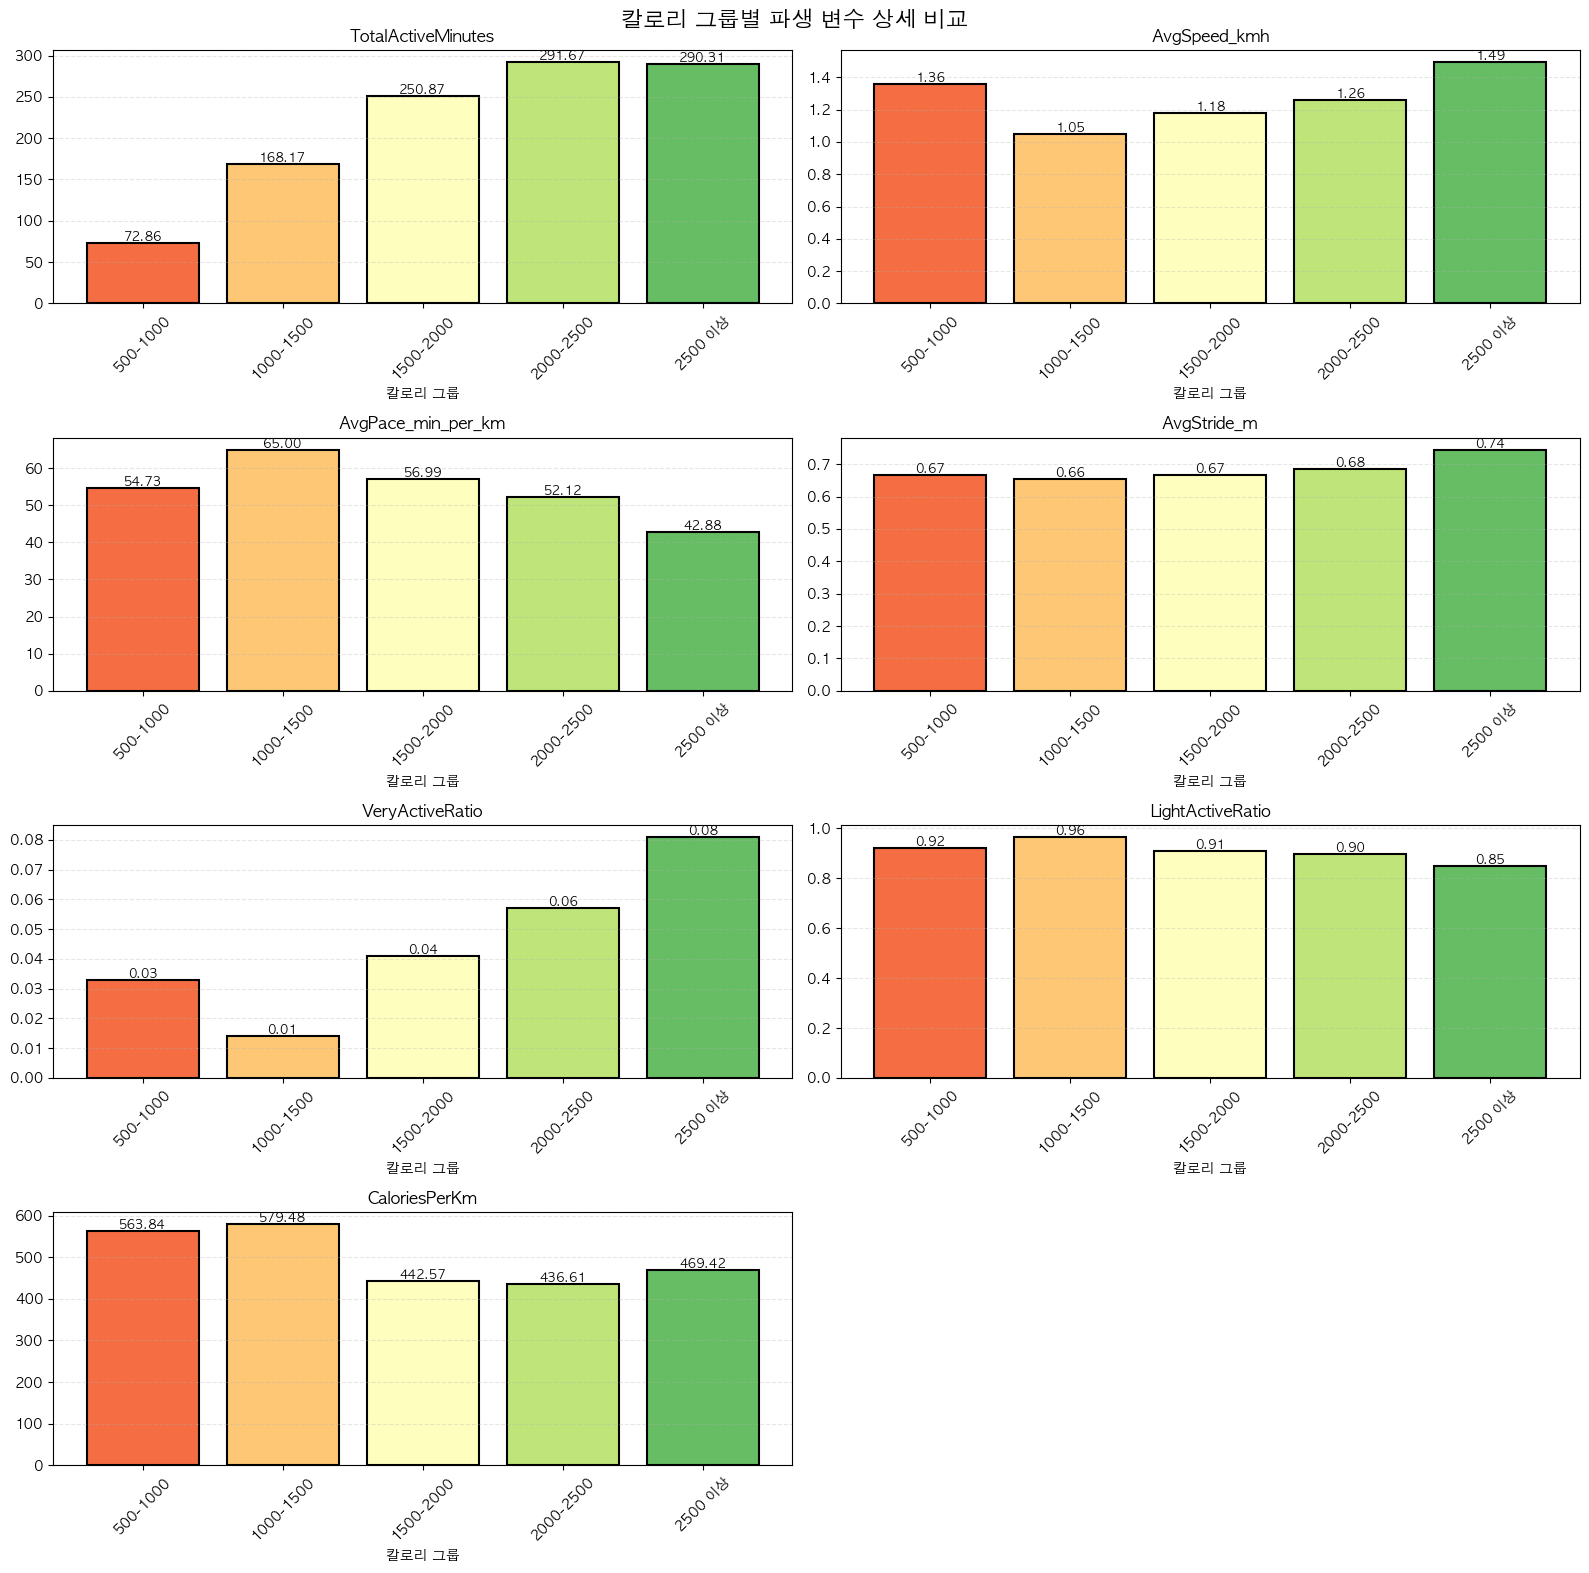

In [340]:
# 2. 변수별로 개별 막대 그래프 (비교하기 쉽게)
fig, axes = plt.subplots(4, 2, figsize=(16, 16))
axes = axes.flatten()

colors_gradient = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(calorie_group_derived)))

for idx, col in enumerate(derived_cols):
    ax = axes[idx]
    bars = ax.bar(calorie_group_derived.index, 
                  calorie_group_derived[col], 
                  color=colors_gradient, 
                  edgecolor='black',
                  linewidth=1.5)
    
    # 값 표시
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax.set_title(f'{col}', fontsize=12, fontweight='bold')
    ax.set_xlabel('칼로리 그룹', fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, axis='y', linestyle='--')

# 마지막 subplot 제거
fig.delaxes(axes[-1])

plt.suptitle('칼로리 그룹별 파생 변수 상세 비교', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

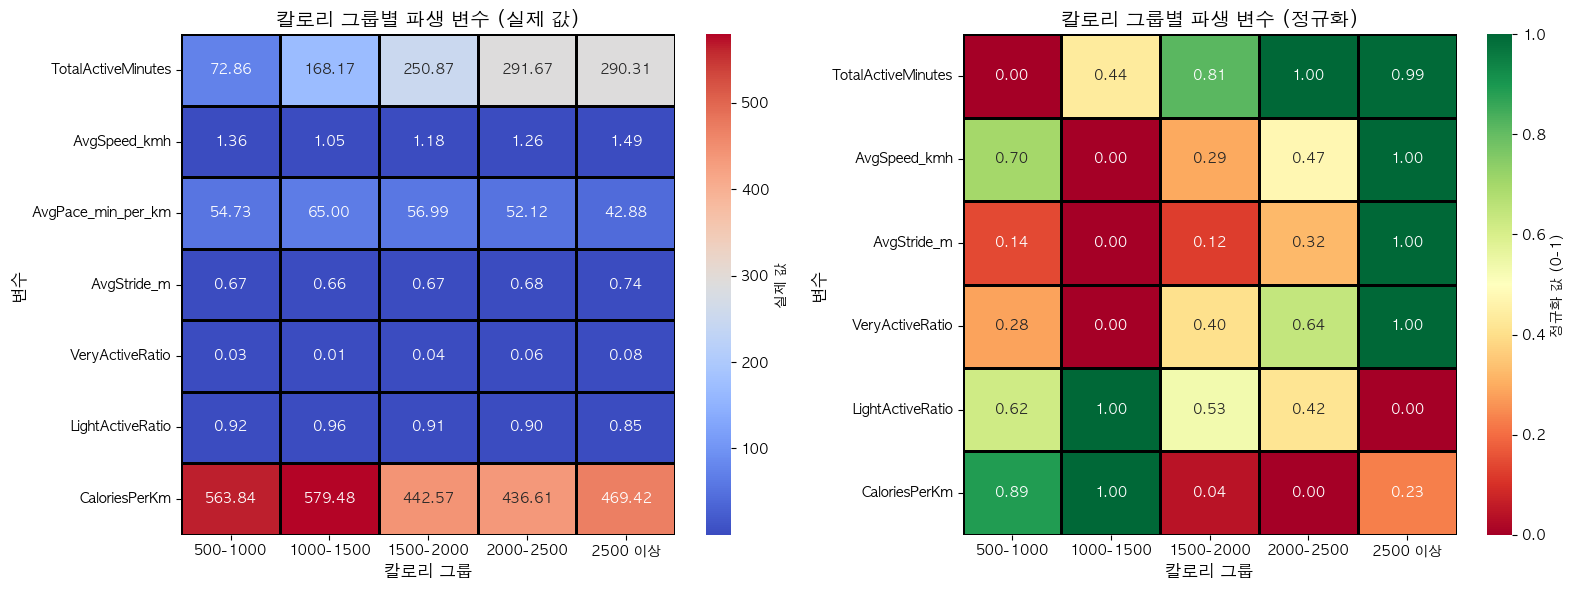

In [341]:
# 3. 히트맵 (더 명확한 색상)
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 원본 값 히트맵
sns.heatmap(calorie_group_derived.T, annot=True, fmt='.2f', 
            cmap='coolwarm', cbar_kws={'label': '실제 값'}, 
            linewidths=1, linecolor='black', ax=axes[0])
axes[0].set_title('칼로리 그룹별 파생 변수 (실제 값)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('칼로리 그룹', fontsize=12)
axes[0].set_ylabel('변수', fontsize=12)

# 정규화된 값 히트맵
sns.heatmap(calorie_group_derived_normalized.T, annot=True, fmt='.2f', 
            cmap='RdYlGn', cbar_kws={'label': '정규화 값 (0-1)'}, 
            linewidths=1, linecolor='black', ax=axes[1],
            vmin=0, vmax=1)
axes[1].set_title('칼로리 그룹별 파생 변수 (정규화)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('칼로리 그룹', fontsize=12)
axes[1].set_ylabel('변수', fontsize=12)

plt.tight_layout()
plt.show()

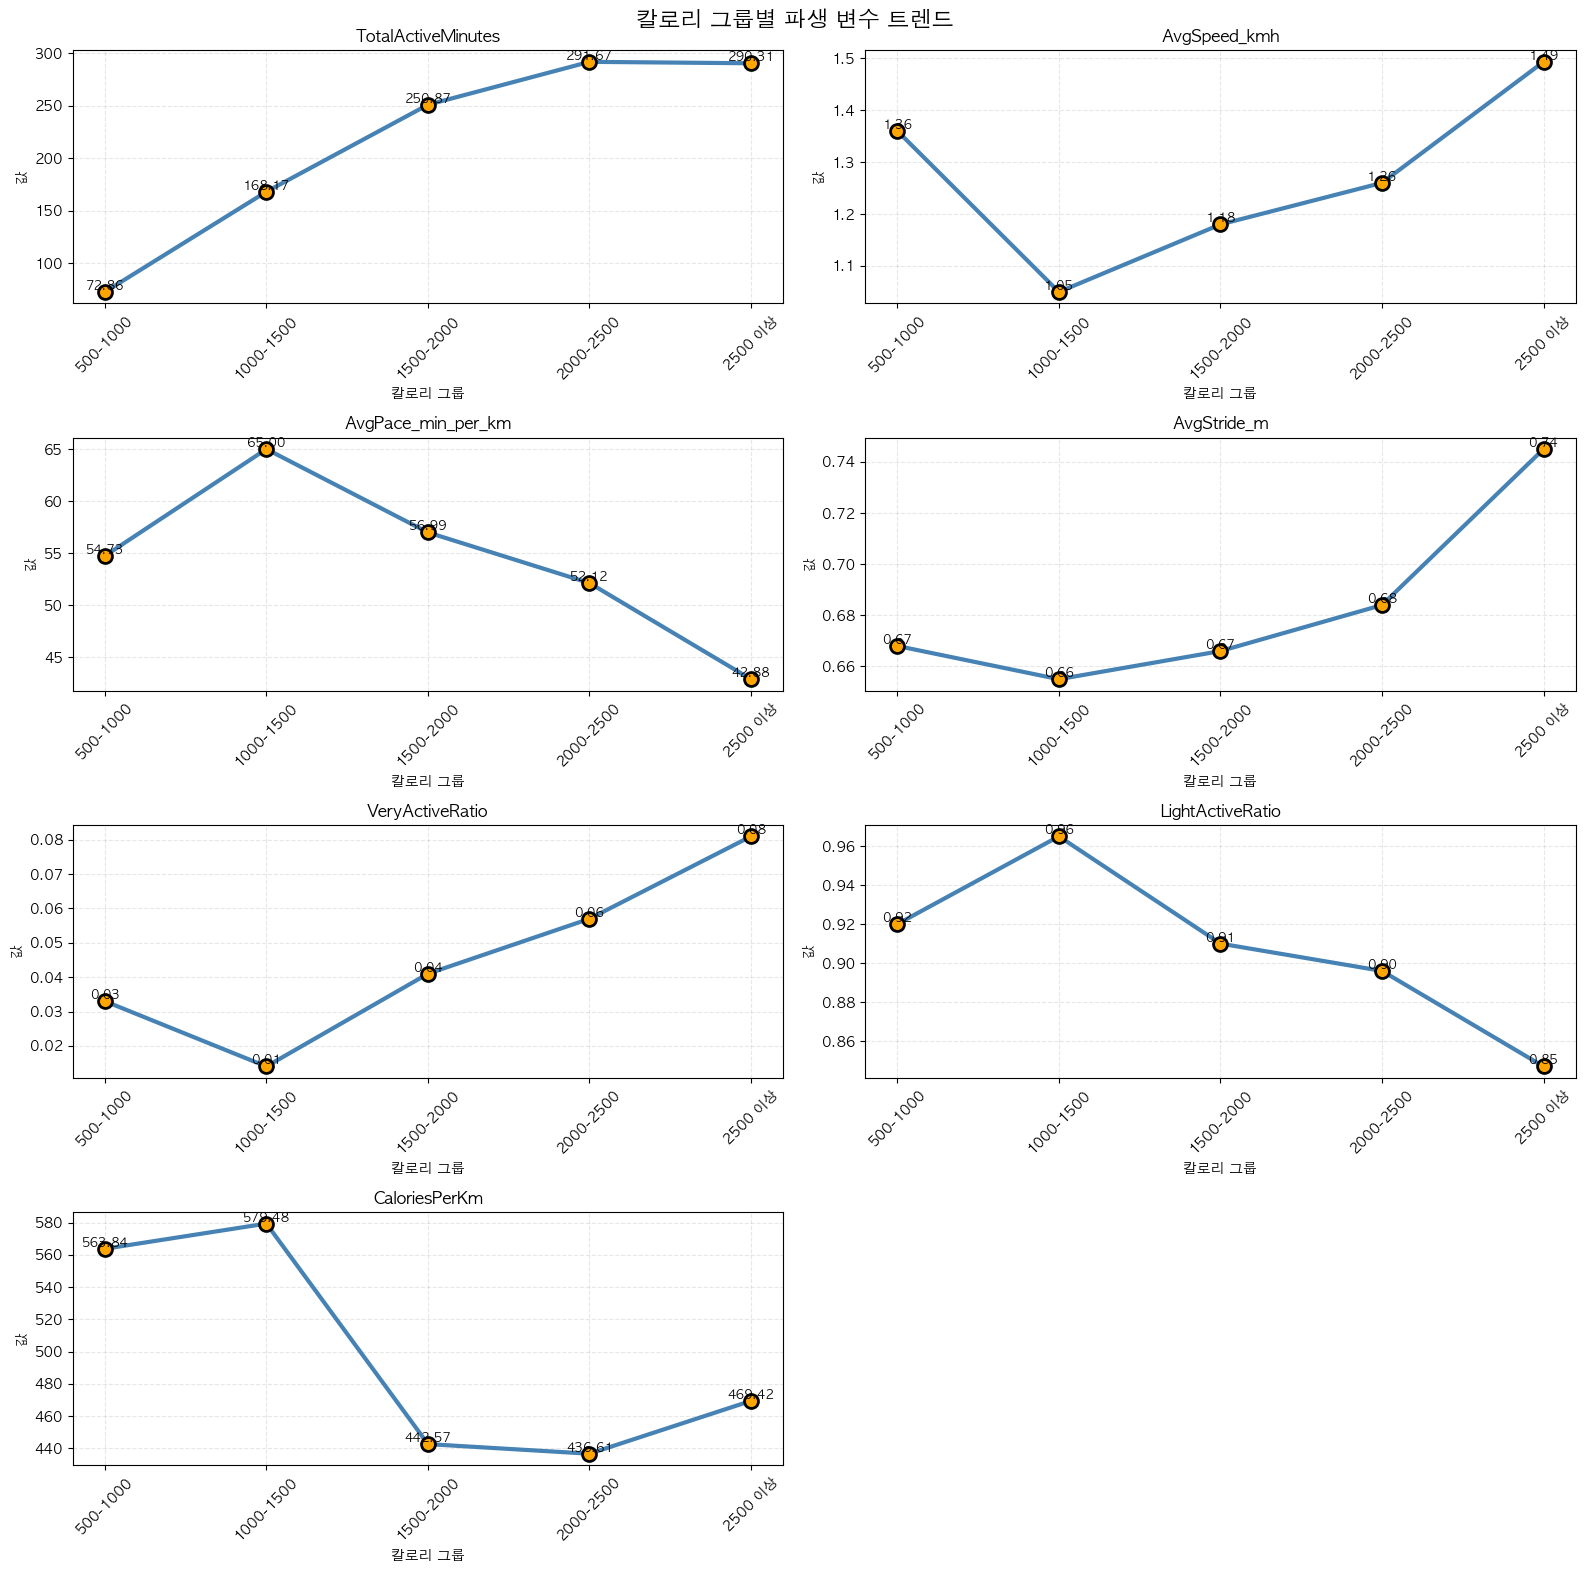

In [342]:
# 4. 라인 차트 (트렌드 파악)
fig, axes = plt.subplots(4, 2, figsize=(16, 16))
axes = axes.flatten()

markers = ['o', 's', '^', 'D', 'v', '<', '>']

for idx, col in enumerate(derived_cols):
    ax = axes[idx]
    ax.plot(range(len(calorie_group_derived)), 
            calorie_group_derived[col], 
            marker='o', linewidth=3, markersize=10,
            color='steelblue', markerfacecolor='orange', 
            markeredgewidth=2, markeredgecolor='black')
    
    # 값 표시
    for i, (x, y) in enumerate(zip(range(len(calorie_group_derived)), 
                                    calorie_group_derived[col])):
        ax.text(x, y, f'{y:.2f}', ha='center', va='bottom', 
                fontsize=9, fontweight='bold')
    
    ax.set_title(f'{col}', fontsize=12, fontweight='bold')
    ax.set_xlabel('칼로리 그룹', fontsize=10)
    ax.set_ylabel('값', fontsize=10)
    ax.set_xticks(range(len(calorie_group_derived)))
    ax.set_xticklabels(calorie_group_derived.index, rotation=45)
    ax.grid(True, alpha=0.3, linestyle='--')

# 마지막 subplot 제거
fig.delaxes(axes[-1])

plt.suptitle('칼로리 그룹별 파생 변수 트렌드', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

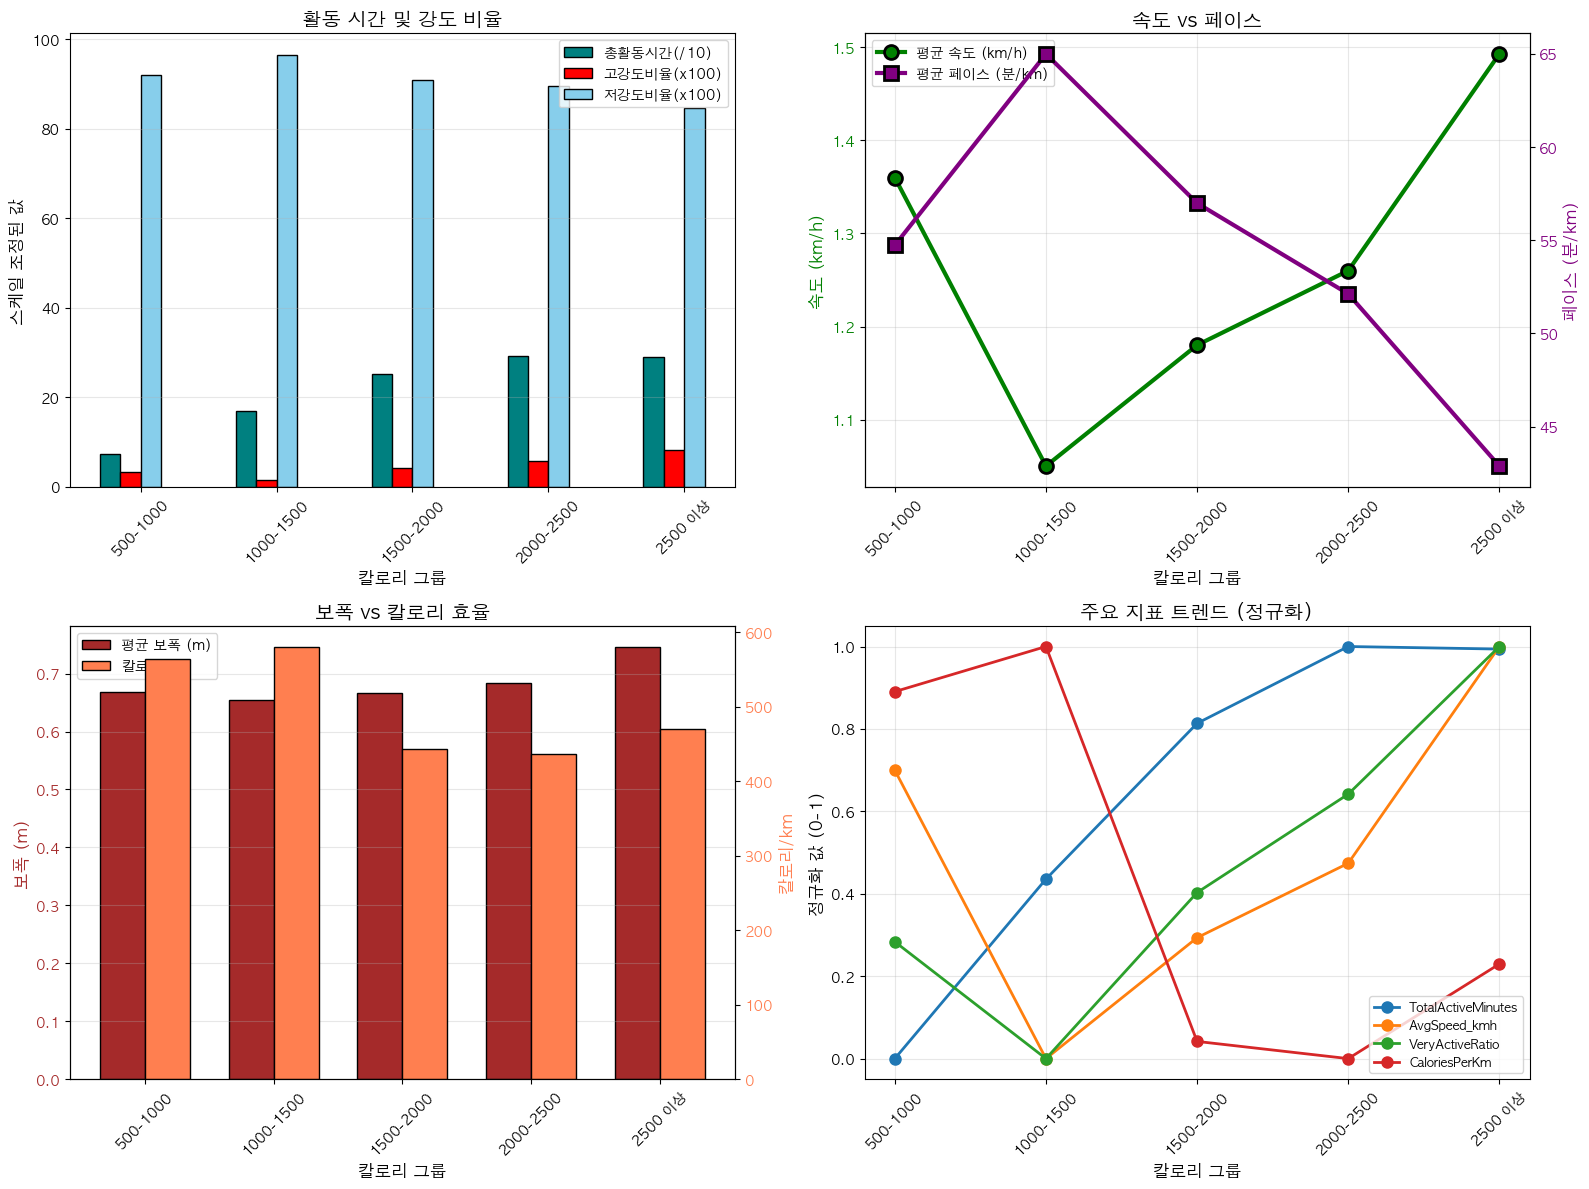

In [343]:
# 5. 그룹화된 비교 (관련 변수끼리)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 5-1. 활동 시간 & 비율
ax = axes[0, 0]
x = np.arange(len(calorie_group_derived))
width = 0.15

ax.bar(x - width*1.5, calorie_group_derived['TotalActiveMinutes']/10, 
       width, label='총활동시간(/10)', color='teal', edgecolor='black')
ax.bar(x - width*0.5, calorie_group_derived['VeryActiveRatio']*100, 
       width, label='고강도비율(x100)', color='red', edgecolor='black')
ax.bar(x + width*0.5, calorie_group_derived['LightActiveRatio']*100, 
       width, label='저강도비율(x100)', color='skyblue', edgecolor='black')

ax.set_xlabel('칼로리 그룹', fontsize=12)
ax.set_ylabel('스케일 조정된 값', fontsize=12)
ax.set_title('활동 시간 및 강도 비율', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(calorie_group_derived.index, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 5-2. 속도 & 페이스
ax = axes[0, 1]
ax2 = ax.twinx()

line1 = ax.plot(calorie_group_derived['AvgSpeed_kmh'], 
                marker='o', linewidth=3, markersize=10, 
                color='green', label='평균 속도 (km/h)', markeredgecolor='black', markeredgewidth=2)
line2 = ax2.plot(calorie_group_derived['AvgPace_min_per_km'], 
                 marker='s', linewidth=3, markersize=10, 
                 color='purple', label='평균 페이스 (분/km)', markeredgecolor='black', markeredgewidth=2)

ax.set_xlabel('칼로리 그룹', fontsize=12)
ax.set_ylabel('속도 (km/h)', fontsize=12, color='green')
ax2.set_ylabel('페이스 (분/km)', fontsize=12, color='purple')
ax.set_title('속도 vs 페이스', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(calorie_group_derived)))
ax.set_xticklabels(calorie_group_derived.index, rotation=45)
ax.tick_params(axis='y', labelcolor='green')
ax2.tick_params(axis='y', labelcolor='purple')
ax.grid(True, alpha=0.3)

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc='upper left')

# 5-3. 보폭 & 칼로리 효율
ax = axes[1, 0]
x = np.arange(len(calorie_group_derived))
width = 0.35

bars1 = ax.bar(x - width/2, calorie_group_derived['AvgStride_m'], 
               width, label='평균 보폭 (m)', color='brown', edgecolor='black')
ax2 = ax.twinx()
bars2 = ax2.bar(x + width/2, calorie_group_derived['CaloriesPerKm'], 
                width, label='칼로리/km', color='coral', edgecolor='black')

ax.set_xlabel('칼로리 그룹', fontsize=12)
ax.set_ylabel('보폭 (m)', fontsize=12, color='brown')
ax2.set_ylabel('칼로리/km', fontsize=12, color='coral')
ax.set_title('보폭 vs 칼로리 효율', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(calorie_group_derived.index, rotation=45)
ax.tick_params(axis='y', labelcolor='brown')
ax2.tick_params(axis='y', labelcolor='coral')
ax.grid(True, alpha=0.3, axis='y')

lines = [bars1, bars2]
labels = ['평균 보폭 (m)', '칼로리/km']
ax.legend(lines, labels, loc='upper left')

# 5-4. 종합 비교 (정규화)
ax = axes[1, 1]
calorie_group_derived_normalized[['TotalActiveMinutes', 'AvgSpeed_kmh', 
                                   'VeryActiveRatio', 'CaloriesPerKm']].plot(
    kind='line', marker='o', linewidth=2, markersize=8, ax=ax
)
ax.set_xlabel('칼로리 그룹', fontsize=12)
ax.set_ylabel('정규화 값 (0-1)', fontsize=12)
ax.set_title('주요 지표 트렌드 (정규화)', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(calorie_group_derived)))
ax.set_xticklabels(calorie_group_derived.index, rotation=45)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

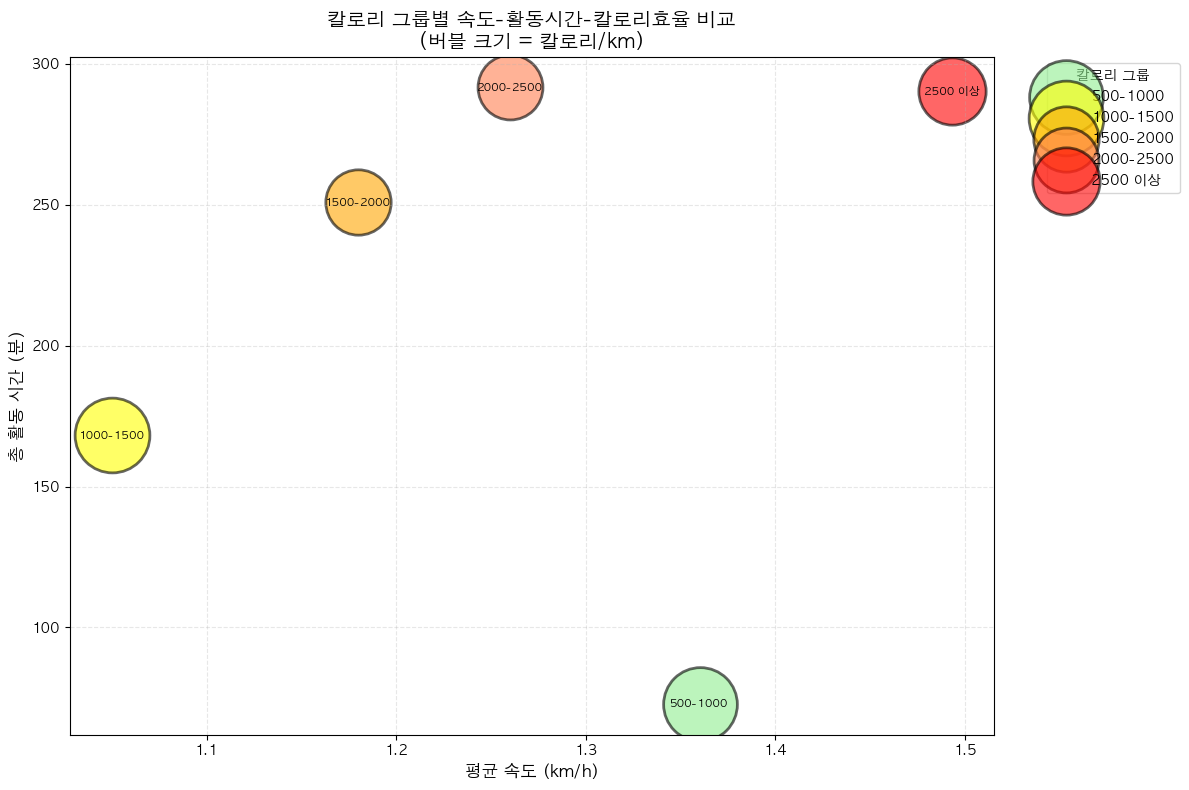

In [335]:
# 6. 버블 차트 (3개 변수 동시 비교)
plt.figure(figsize=(12, 8))

colors_map = {'500 이하': 'lightblue', '500-1000': 'lightgreen', 
              '1000-1500': 'yellow', '1500-2000': 'orange', 
              '2000-2500': 'coral', '2500 이상': 'red'}

for group in calorie_group_derived.index:
    plt.scatter(calorie_group_derived.loc[group, 'AvgSpeed_kmh'],
                calorie_group_derived.loc[group, 'TotalActiveMinutes'],
                s=calorie_group_derived.loc[group, 'CaloriesPerKm']*5,
                c=colors_map[group],
                alpha=0.6,
                edgecolors='black',
                linewidth=2,
                label=group)
    
    plt.text(calorie_group_derived.loc[group, 'AvgSpeed_kmh'],
             calorie_group_derived.loc[group, 'TotalActiveMinutes'],
             group, ha='center', va='center', fontsize=8, fontweight='bold')

plt.xlabel('평균 속도 (km/h)', fontsize=12)
plt.ylabel('총 활동 시간 (분)', fontsize=12)
plt.title('칼로리 그룹별 속도-활동시간-칼로리효율 비교\n(버블 크기 = 칼로리/km)', 
          fontsize=14, fontweight='bold')
plt.legend(title='칼로리 그룹', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

=== 사용자별 분석 ===

[상위 5명 - 평균 걸음수]
        Id   TotalSteps    Calories
1503960366 12405.195652 1882.065217
7007744171 12351.411765 2706.823529
2022484408 11707.243902 2536.170732
8053475328 11225.285714 2740.428571
6962181067 11022.666667 2055.119048

[하위 5명 - 평균 걸음수]
        Id  TotalSteps    Calories
1927972279 4145.600000 2593.000000
1844505072 4984.000000 1823.695652
2320127002 5161.531250 1741.031250
4445114986 5271.297297 2256.243243
2026352035 5296.179487 1512.179487

상위 5명 평균: 11742 steps/day
하위 5명 평균: 4972 steps/day
격차: 2.4배


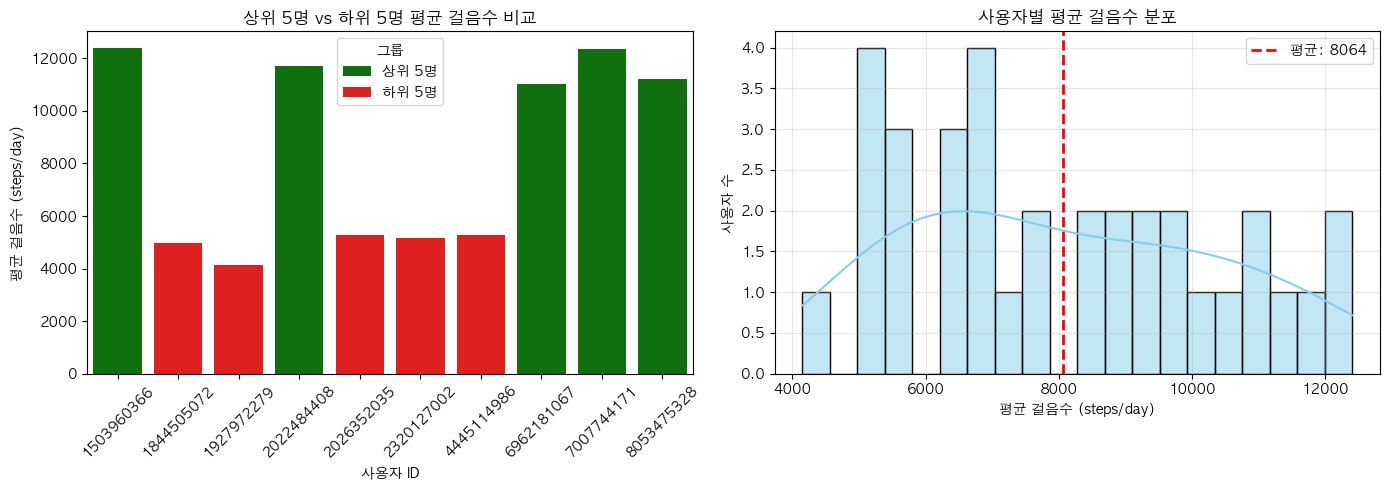

In [347]:
# actcp_d_clean으로 사용자별 분석
user_summary = actcp_d_clean.groupby('Id').agg({
    'TotalSteps': 'mean',
    'Calories': 'mean',
    'TotalActiveMinutes': 'mean'
}).reset_index()

top5 = user_summary.nlargest(5, 'TotalSteps')
bottom5 = user_summary.nsmallest(5, 'TotalSteps')

# 사용자별 분석
print("=== 사용자별 분석 ===")

# 상위/하위 사용자 정보 출력
print("\n[상위 5명 - 평균 걸음수]")
print(top5[['Id', 'TotalSteps', 'Calories']].to_string(index=False))

print("\n[하위 5명 - 평균 걸음수]")
print(bottom5[['Id', 'TotalSteps', 'Calories']].to_string(index=False))

# 격차 계산
print(f"\n상위 5명 평균: {top5['TotalSteps'].mean():.0f} steps/day")
print(f"하위 5명 평균: {bottom5['TotalSteps'].mean():.0f} steps/day")
print(f"격차: {top5['TotalSteps'].mean() / bottom5['TotalSteps'].mean():.1f}배")

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1) 상위 5명 vs 하위 5명 비교
combined = pd.concat([
    top5.assign(group='상위 5명'),
    bottom5.assign(group='하위 5명')
])
sns.barplot(data=combined, x='Id', y='TotalSteps', hue='group', 
            ax=axes[0], palette=['green', 'red'])
axes[0].set_xlabel('사용자 ID')
axes[0].set_ylabel('평균 걸음수 (steps/day)')
axes[0].set_title('상위 5명 vs 하위 5명 평균 걸음수 비교', fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(title='그룹')

# 2) 전체 사용자 분포
sns.histplot(data=user_summary, x='TotalSteps', bins=20, kde=True, 
             ax=axes[1], color='skyblue', edgecolor='black')
axes[1].axvline(user_summary['TotalSteps'].mean(), color='red', linestyle='--', 
                linewidth=2, label=f"평균: {user_summary['TotalSteps'].mean():.0f}")
axes[1].set_xlabel('평균 걸음수 (steps/day)')
axes[1].set_ylabel('사용자 수')
axes[1].set_title('사용자별 평균 걸음수 분포', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


=== Steps vs Calories 상관관계 ===
상관계수: 0.407


/var/folders/wc/4jpr72gn34v7gndmn2_zk9680000gn/T/ipykernel_60720/2989089190.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


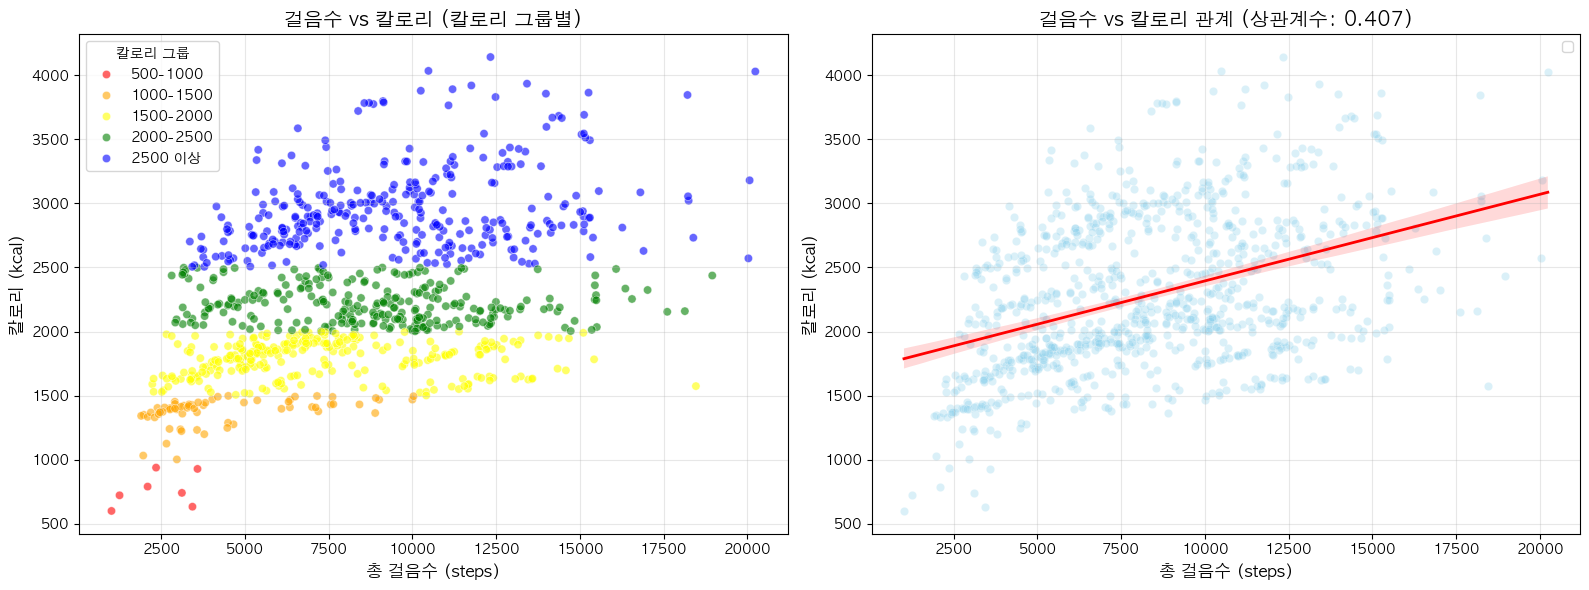

In [349]:
# Steps vs Calories 관계 분석 (정제된 데이터 사용)
print("\n=== Steps vs Calories 상관관계 ===")
correlation = actcp_d_clean['TotalSteps'].corr(actcp_d_clean['Calories'])
print(f"상관계수: {correlation:.3f}")

# 칼로리 그룹 생성 (500 미만 제외, 5000 초과도 제외)
actcp_d_clean = actcp_d_clean[
    (actcp_d_clean['Calories'] >= 500) & 
    (actcp_d_clean['Calories'] <= 5000)
].copy()

actcp_d_clean['CalorieGroup'] = pd.cut(
    actcp_d_clean['Calories'],
    bins=[500, 1000, 1500, 2000, 2500, 5000],
    labels=['500-1000', '1000-1500', '1500-2000', '2000-2500', '2500 이상'],
    include_lowest=True
)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1) 칼로리 그룹별 산점도
sns.scatterplot(data=actcp_d_clean, x='TotalSteps', y='Calories', 
                hue='CalorieGroup', alpha=0.6, ax=axes[0],
                palette=['red', 'orange', 'yellow', 'green', 'blue'])
axes[0].set_xlabel('총 걸음수 (steps)', fontsize=12)
axes[0].set_ylabel('칼로리 (kcal)', fontsize=12)
axes[0].set_title('걸음수 vs 칼로리 (칼로리 그룹별)', fontsize=14, fontweight='bold')
axes[0].legend(title='칼로리 그룹', loc='upper left')
axes[0].grid(True, alpha=0.3)

# 2) 회귀선 포함 산점도
sns.scatterplot(data=actcp_d_clean, x='TotalSteps', y='Calories', 
                alpha=0.3, color='skyblue', ax=axes[1])
sns.regplot(data=actcp_d_clean, x='TotalSteps', y='Calories', 
            scatter=False, color='red', ax=axes[1], 
            line_kws={'linewidth': 2, 'label': f'회귀선 (r={correlation:.3f})'})
axes[1].set_xlabel('총 걸음수 (steps)', fontsize=12)
axes[1].set_ylabel('칼로리 (kcal)', fontsize=12)
axes[1].set_title(f'걸음수 vs 칼로리 관계 (상관계수: {correlation:.3f})', 
                 fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()